## Author: Denys Herasymuk

**Variant**: the remainder of the division = 3

## Contents of This Notebook

Click on the section and go to this cell immediately.

* [Section 1. Explore Data](#section_1)
* [Section 2. Identifying Stationarity](#section_2)
* [Section 3. Nonstationary-to-Stationary Transformations](#section_3)
* [Section 4. Correlation analysis](#section_4)
* [Section 5. Feature generation and validation of DL models](#section_5)
* [Section 6. Fbprophet and Nbeats models](#section_6)
* [Section 7. Predict on 12 months out of dataframe](#section_7)


When you use Run All button with this notebook, you should wait approx. 10-15 mins to get output of all cells.

**How to run this notebook**

* Create a new conda env with python 3.7
* Run `jupyter notebook` in your new env via terminal (without installing any packages now)
* Based on (this link)[https://stackoverflow.com/questions/61353951/no-module-named-fbprophet]. Run these two cells in your jupyter:
```
!conda install -c conda-forge fbprophet -y
!conda install -c conda-forge tensorboard -y
!pip install --upgrade plotly
```

* In terminal run  -- `pip install -r requirements.txt`
* In any case, a useful command -- `conda create --clone py35 --name py35-2` from here -- https://docs.conda.io/projects/conda/en/4.6.0/_downloads/52a95608c49671267e40c689e0bc00ca/conda-cheatsheet.pdf

* How to install pytorch -- https://pytorch.org/get-started/locally/
* In such a way I installed it on Ubuntu
`pip3 install torch==1.10.0+cpu torchvision==0.11.1+cpu torchaudio==0.10.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html`

* Nbeats installing -- `pip3 install nbeats-pytorch`

## General Configuration

In [1]:
import os
import sys
import math
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import tensorflow as tf
import statsmodels as ss
import matplotlib.pyplot as plt

import xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
# from fbprophet import Prophet
# from prophet.diagnostics import performance_metrics, cross_validation
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector

from pprint import pprint
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller

from constants import *

Using TensorFlow backend.


In [2]:
%matplotlib inline

alt.data_transformers.disable_max_rows()
alt.renderers.enable('html')

plt.style.use('mpl20')
# plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

## Python & Library Versions

In [3]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("statsmodels", ss.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__),
             ("keras", keras.__version__),
             ("xgboost", xgboost.__version__),
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.7.13 (default, Mar 29 2022, 02:18:16) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.4
statsmodels 0.12.2
seaborn     0.11.2
sklearn     1.0.2
keras       2.3.1
xgboost     1.5.0


<a id='section_1'></a>

## Section 1. Explore Data

In [4]:
original_df = pd.read_csv(os.path.join("..", "data", "dataset1_SolarPrediction.csv"))

In [5]:
original_df.head(10)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
5,1475227824,9/29/2016 12:00:00 AM,23:30:24,1.21,48,30.46,64,120.20,5.62,06:13:00,18:13:00
6,1475227519,9/29/2016 12:00:00 AM,23:25:19,1.20,49,30.46,72,112.45,6.75,06:13:00,18:13:00
7,1475227222,9/29/2016 12:00:00 AM,23:20:22,1.24,49,30.46,71,122.97,5.62,06:13:00,18:13:00
8,1475226922,9/29/2016 12:00:00 AM,23:15:22,1.23,49,30.46,80,101.18,4.50,06:13:00,18:13:00
9,1475226622,9/29/2016 12:00:00 AM,23:10:22,1.21,49,30.46,85,141.87,4.50,06:13:00,18:13:00


In [6]:
original_df = original_df[:5000]

In [7]:
original_df.shape

(5000, 11)

In [8]:
original_df.columns

Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')

In [9]:
original_df.dtypes

UNIXTime                    int64
Data                       object
Time                       object
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
TimeSunRise                object
TimeSunSet                 object
dtype: object

In [10]:
original_df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,1.474444e+09,244.137338,54.401600,30.436096,77.94500,131.469812,5.487334
std,4.673856e+05,350.818129,5.890675,0.035707,20.78611,86.008711,2.858449
min,1.473619e+09,1.150000,43.000000,30.360000,15.00000,0.100000,0.000000
25%,1.474073e+09,1.240000,50.000000,30.410000,65.00000,58.110000,3.370000
50%,1.474462e+09,9.930000,54.000000,30.440000,84.00000,140.925000,5.620000
75%,1.474842e+09,423.190000,59.000000,30.460000,96.00000,175.267500,6.750000
max,1.475229e+09,1387.170000,71.000000,30.530000,102.00000,359.930000,20.250000


In [11]:
original_df.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

In [12]:
# area_df.Area_New = area_df.Area_New.interpolate()

## Data Preprocessing

### Transformation for sun duration

In [13]:
datetime_series = original_df.copy()
datetime_series.index = pd.to_datetime(datetime_series['UNIXTime'], unit='s') - timedelta(hours=10)  # also include timezone shift

datetime_series['Sun_Day_Duration'] = pd.to_datetime(datetime_series['TimeSunSet'], format='%H:%M:%S') - \
                                      pd.to_datetime(datetime_series['TimeSunRise'], format='%H:%M:%S')
datetime_series['Sun_Day_Duration'] = round(datetime_series['Sun_Day_Duration'].dt.seconds / 3600, 2)
datetime_series['DateTime'] = datetime_series.index
datetime_series.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Sun_Day_Duration,DateTime
UNIXTime,,,,,,,,,,,,,
2016-09-29 23:55:26,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,12.0,2016-09-29 23:55:26
2016-09-29 23:50:23,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:50:23
2016-09-29 23:45:26,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:45:26
2016-09-29 23:40:21,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:40:21
2016-09-29 23:35:24,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,12.0,2016-09-29 23:35:24


### UNIX time to datetime transformation

In [14]:
radiation_df = datetime_series.drop(['UNIXTime', 'Data', 'Time'], axis=1)

In [15]:
radiation_df['Year'] = radiation_df.DateTime.dt.year
radiation_df['Month'] = radiation_df.DateTime.dt.month
radiation_df['Day'] = radiation_df.DateTime.dt.day
radiation_df['Hour'] = radiation_df.DateTime.dt.hour
radiation_df['Day_of_week'] = radiation_df.DateTime.dt.dayofweek

In [16]:
def weekend_transform(row):
    return int(row.dayofweek == 5 or row.dayofweek == 6)

radiation_df['Weekend'] = radiation_df['DateTime'].apply(weekend_transform)
radiation_df['Hourly_DateTime'] = pd.to_datetime(dict(year=radiation_df.Year, month=radiation_df.Month, day=radiation_df.Day, hour=radiation_df.Hour))

In [17]:
radiation_df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Sun_Day_Duration,DateTime,Year,Month,Day,Hour,Day_of_week,Weekend,Hourly_DateTime
UNIXTime,,,,,,,,,,,,,,,,,
2016-09-29 23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,12.0,2016-09-29 23:55:26,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:50:23,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:45:26,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,12.0,2016-09-29 23:40:21,2016,9,29,23,3,0,2016-09-29 23:00:00
2016-09-29 23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,12.0,2016-09-29 23:35:24,2016,9,29,23,3,0,2016-09-29 23:00:00


In [18]:
print(f'Data time range: from {radiation_df.DateTime.unique().min()} to {radiation_df.DateTime.unique().max()}')

Data time range: from 2016-09-11T08:40:20.000000000 to 2016-09-29T23:55:26.000000000


In [19]:
def set_column_types_to_int(df, column_names):
    for col_name in column_names:
        df[col_name] = df[col_name].astype(int)

# Here we take mean of radiation for each hour, since a number of measures during hour can be different for some days what is bad for sum().
# Secondly, sum of radiation is not accurate sum for radiation during each hour
hourly_radiation_df = radiation_df.groupby(['Hourly_DateTime']).mean().copy()
# hourly_radiation_df['Radiation'] = radiation_df.groupby(['Hourly_DateTime'])['Radiation'].sum().copy()
# hourly_radiation_df['Log_Radiation'] = np.log(radiation_df.groupby(['Hourly_DateTime'])['Radiation'].sum().copy())
hourly_radiation_df['Log_Radiation'] = np.log(radiation_df.groupby(['Hourly_DateTime'])['Radiation'].mean().copy())
set_column_types_to_int(hourly_radiation_df, ['Year', 'Month', 'Day', 'Hour', 'Day_of_week', 'Weekend'])
hourly_radiation_df.head(20)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Sun_Day_Duration,Year,Month,Day,Hour,Day_of_week,Weekend,Log_Radiation
Hourly_DateTime,,,,,,,,,,,,,,
2016-09-11 08:00:00,638.927500,58.250000,30.490000,48.000000,198.712500,4.215000,12.33,2016,9,11,8,6,1,6.459791
2016-09-11 09:00:00,779.866667,59.166667,30.500000,59.500000,53.563333,4.684167,12.33,2016,9,11,9,6,1,6.659123
2016-09-11 10:00:00,901.528333,60.500000,30.500000,74.250000,50.269167,7.310000,12.33,2016,9,11,10,6,1,6.804091
2016-09-11 11:00:00,495.330909,60.636364,30.495455,77.454545,127.091818,6.030909,12.33,2016,9,11,11,6,1,6.205226
2016-09-11 12:00:00,420.120833,60.500000,30.478333,81.083333,34.070000,6.372500,12.33,2016,9,11,12,6,1,6.040542
2016-09-11 13:00:00,170.759167,59.083333,30.466667,87.583333,63.579167,5.810000,12.33,2016,9,11,13,6,1,5.140254
2016-09-11 14:00:00,146.025833,58.000000,30.457500,92.833333,54.449167,4.121667,12.33,2016,9,11,14,6,1,4.983784
2016-09-11 15:00:00,241.700833,58.666667,30.450833,91.583333,98.859167,4.591667,12.33,2016,9,11,15,6,1,5.487701
2016-09-11 16:00:00,105.705000,57.166667,30.458333,95.916667,30.303333,3.185833,12.33,2016,9,11,16,6,1,4.660652


In [20]:
radiation_df['Daily_DateTime'] = pd.to_datetime(dict(year=radiation_df.Year, month=radiation_df.Month, day=radiation_df.Day))
daily_radiation_df = radiation_df.groupby(['Daily_DateTime']).mean().copy()
# daily_radiation_df['Radiation'] = radiation_df.groupby(['Daily_DateTime'])['Radiation'].sum().copy()
# daily_radiation_df['Log_Radiation'] = np.log(radiation_df.groupby(['Daily_DateTime'])['Radiation'].sum().copy())
daily_radiation_df['Log_Radiation'] = np.log(radiation_df.groupby(['Daily_DateTime'])['Radiation'].mean().copy())
daily_radiation_df = daily_radiation_df.drop(['Hour'], axis=1)
set_column_types_to_int(daily_radiation_df, ['Year', 'Month', 'Day', 'Day_of_week', 'Weekend'])
daily_radiation_df.head(20)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Sun_Day_Duration,Year,Month,Day,Day_of_week,Weekend,Log_Radiation
Daily_DateTime,,,,,,,,,,,,,
2016-09-11,230.955519,56.278689,30.483661,88.513661,91.629290,3.852077,12.33,2016,9,11,6,1,5.442225
2016-09-12,154.785603,54.258865,30.486170,85.517730,176.923511,4.589433,12.32,2016,9,12,0,0,5.042041
2016-09-13,182.679537,55.772242,30.437509,82.832740,206.357082,4.501495,12.28,2016,9,13,1,0,5.207733
2016-09-14,172.338475,53.496454,30.426738,89.517730,128.479113,4.612979,12.27,2016,9,14,2,0,5.149460
2016-09-15,39.832214,49.757143,30.432714,97.385714,172.693786,4.031857,12.27,2016,9,15,3,0,3.684676
2016-09-16,308.809297,55.443243,30.465784,92.978378,120.402595,7.374108,12.25,2016,9,16,4,0,5.732724
2016-09-17,195.961352,55.334520,30.468007,91.523132,120.625267,6.283274,12.23,2016,9,17,5,1,5.277917
2016-09-18,265.980618,54.829091,30.450873,81.501818,121.745564,5.082691,12.20,2016,9,18,6,1,5.583423
2016-09-19,335.504400,57.243636,30.426109,43.087273,119.883636,5.553418,12.18,2016,9,19,0,0,5.815635


<a id='section_2'></a>
## Section 2. Identifying Stationarity

In [21]:
def run_sequence_plot(df, y_column, title, from_datetime=None, to_datetime=None):
    if not from_datetime:
        from_datetime = df.index.min()
    if not to_datetime:
        to_datetime = df.index.max()

    plt.plot(df[from_datetime: to_datetime].index, df[y_column][from_datetime: to_datetime].values, color='blue', label="Radiation")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()

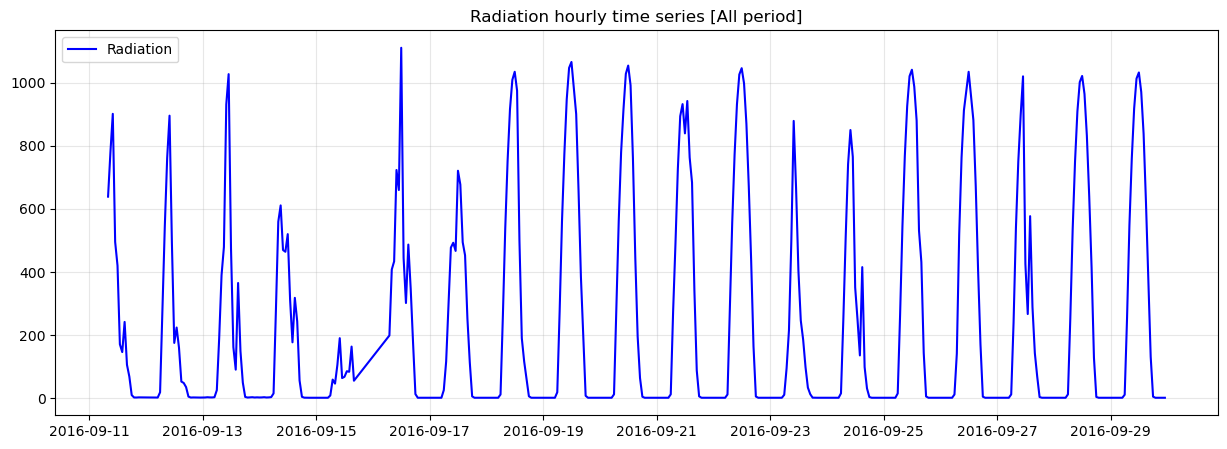

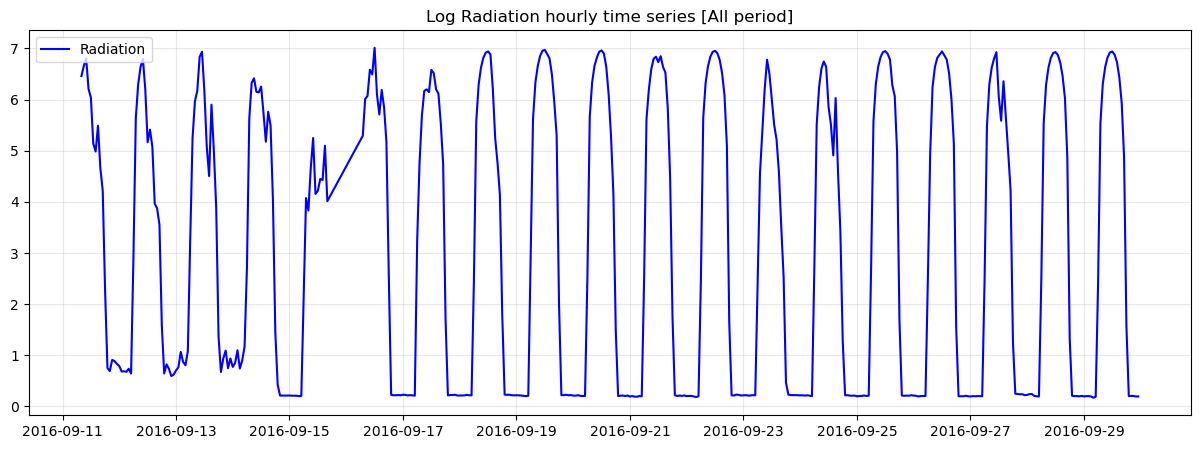

In [22]:
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [All period]')
run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [All period]')

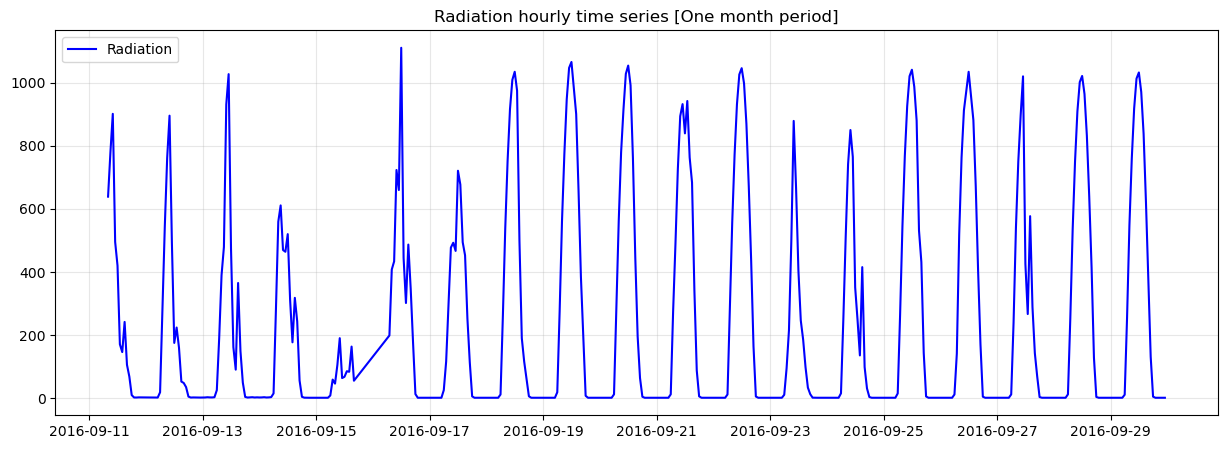

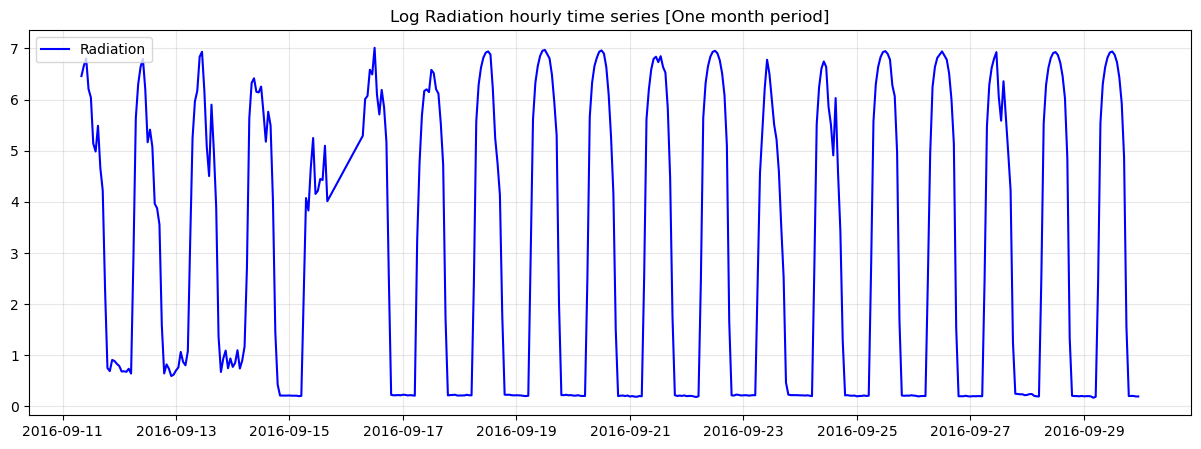

In [23]:
from_datetime = datetime(year=2016, month=9, day=1, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One month period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=30))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One month period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=30))

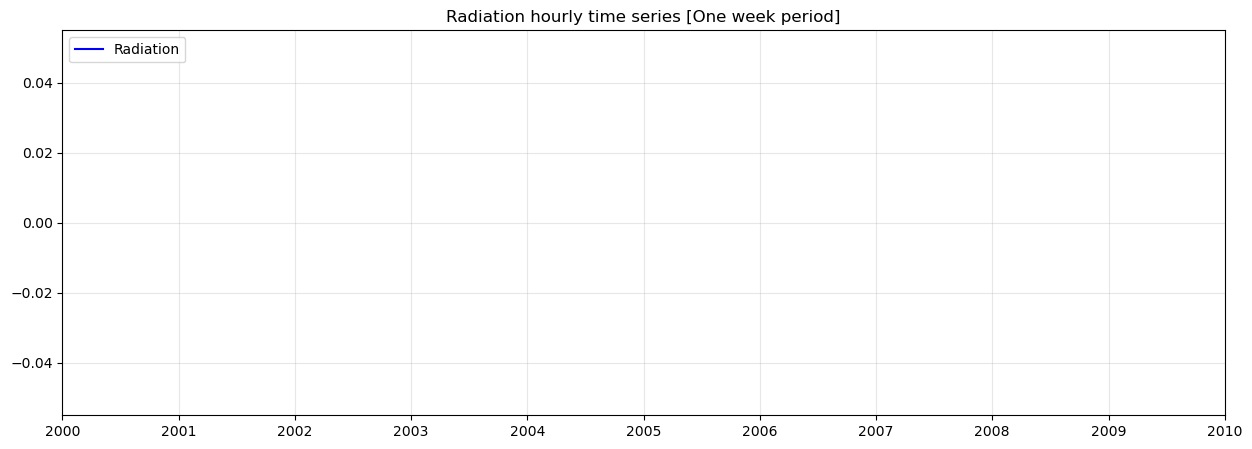

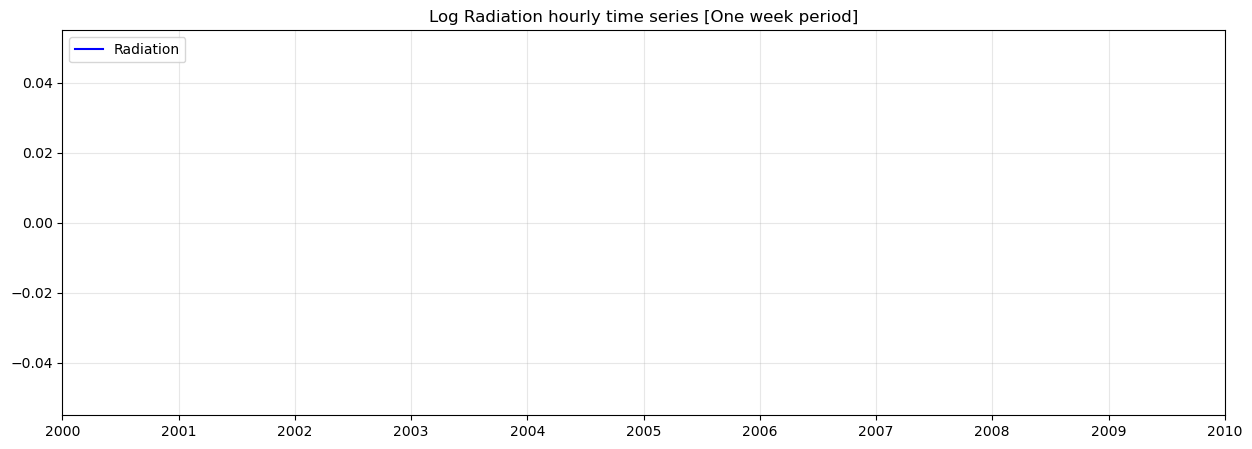

In [24]:
from_datetime = datetime(year=2016, month=9, day=1, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One week period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=7))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One week period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=7))

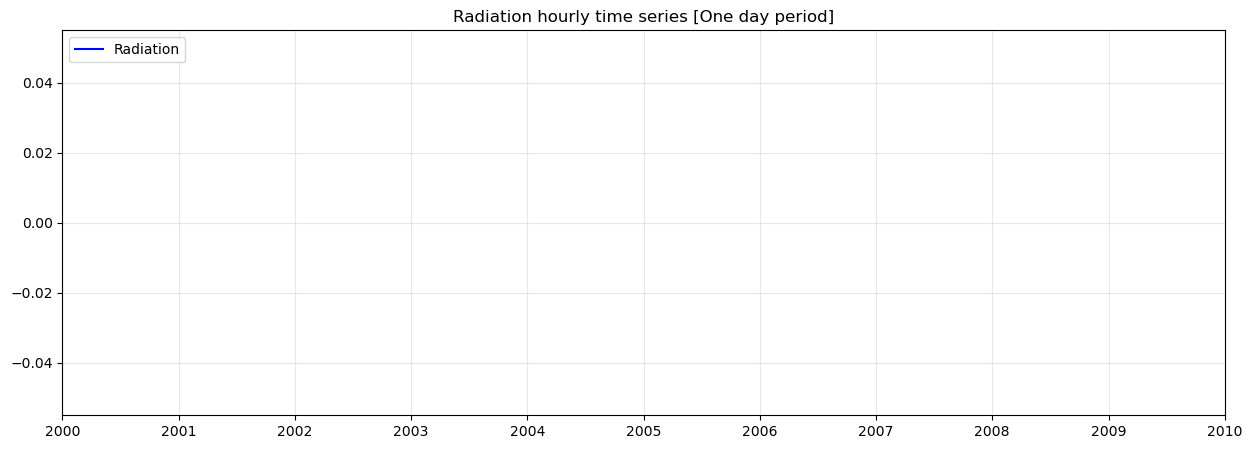

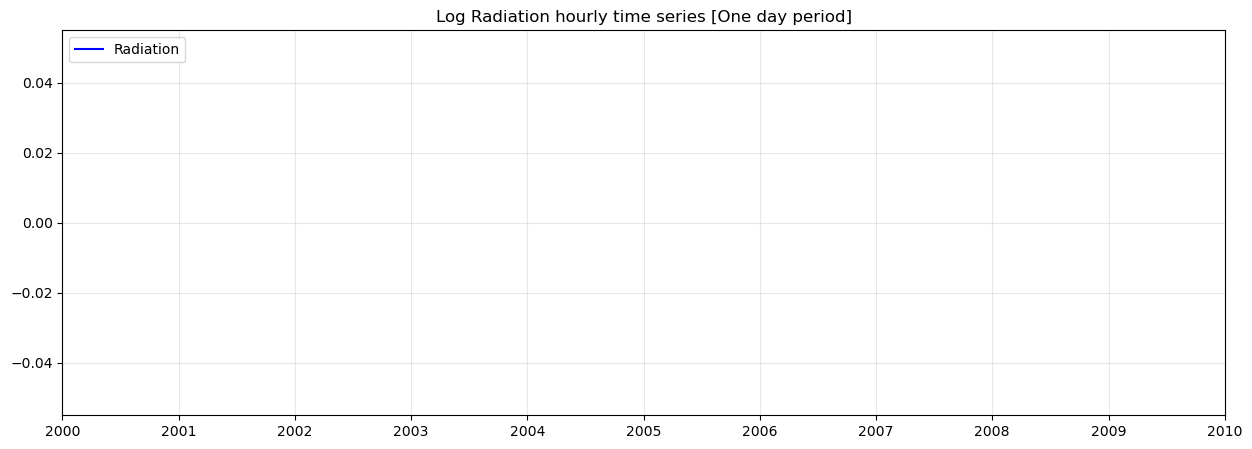

In [25]:
from_datetime = datetime(year=2016, month=9, day=1, hour=0)
run_sequence_plot(hourly_radiation_df, 'Radiation', 'Radiation hourly time series [One day period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=1))

run_sequence_plot(hourly_radiation_df, 'Log_Radiation', 'Log Radiation hourly time series [One day period]',
                  from_datetime = from_datetime,
                  to_datetime = from_datetime + timedelta(days=1))

### Summary Statistics & Plots (additive hypothesis)

First way to check for constant mean and variance is to chop up the data into separate chunks, calculate statistics for each chunk, and compare

In [26]:
hourly_radiation_df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Sun_Day_Duration,Year,Month,Day,Hour,Day_of_week,Weekend,Log_Radiation
Hourly_DateTime,,,,,,,,,,,,,,
2016-09-11 08:00:00,638.927500,58.250000,30.490000,48.000000,198.712500,4.215000,12.33,2016,9,11,8,6,1,6.459791
2016-09-11 09:00:00,779.866667,59.166667,30.500000,59.500000,53.563333,4.684167,12.33,2016,9,11,9,6,1,6.659123
2016-09-11 10:00:00,901.528333,60.500000,30.500000,74.250000,50.269167,7.310000,12.33,2016,9,11,10,6,1,6.804091
2016-09-11 11:00:00,495.330909,60.636364,30.495455,77.454545,127.091818,6.030909,12.33,2016,9,11,11,6,1,6.205226
2016-09-11 12:00:00,420.120833,60.500000,30.478333,81.083333,34.070000,6.372500,12.33,2016,9,11,12,6,1,6.040542


In [27]:
# Compare means and variances
radiation_statistics_df = pd.DataFrame()
radiation_statistics_df['Radiation_Mean'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Radiation'].mean()
radiation_statistics_df['Radiation_Variance'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Radiation'].var()

In [28]:
radiation_statistics_df[['Radiation_Mean', 'Radiation_Variance']]

Radiation_Mean  Radiation_Variance
Year Month Day                                    
2016 9     11       249.331307        92082.180361
           12       154.861495        66895.341318
           13       181.855248        85458.945956
           14       168.789687        46938.759405
           15        55.056005         3388.846892
           16       312.429951       100379.860552
           17       191.711318        61341.767662
           18       266.275948       148253.215726
           19       326.475119       172129.866716
           20       296.462872       161244.407566
           21       292.011920       140603.836324
           22       324.472649       169478.372719
           23       140.031569        57392.559944
           24       184.687049        76177.906959
           25       315.495085       164776.462863
           26       281.971251       149262.340140
           27       218.622911       100262.267973
           28       311.676256       159898.068372
           29       312.221566       162130.786581

#### Histograms

<AxesSubplot:>

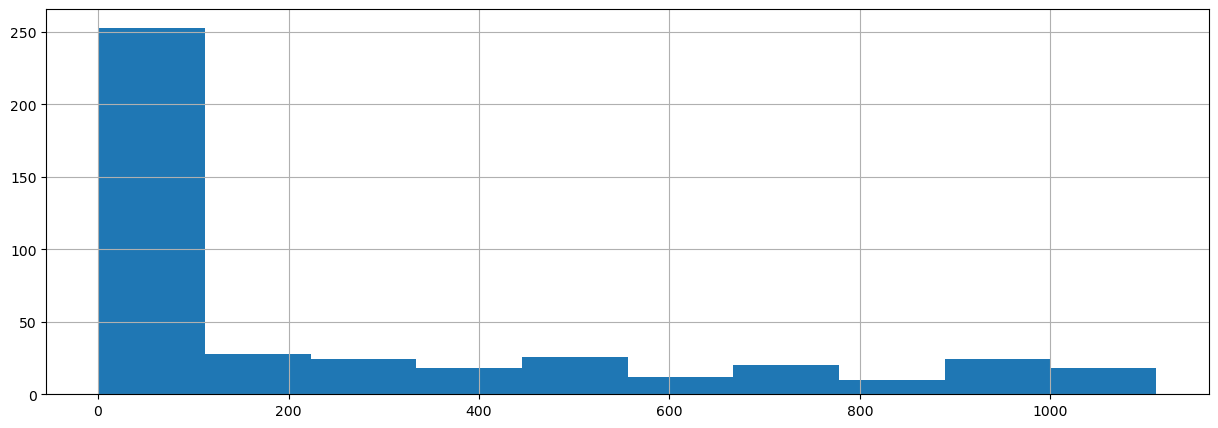

In [29]:
hourly_radiation_df.Radiation.hist()

<AxesSubplot:>

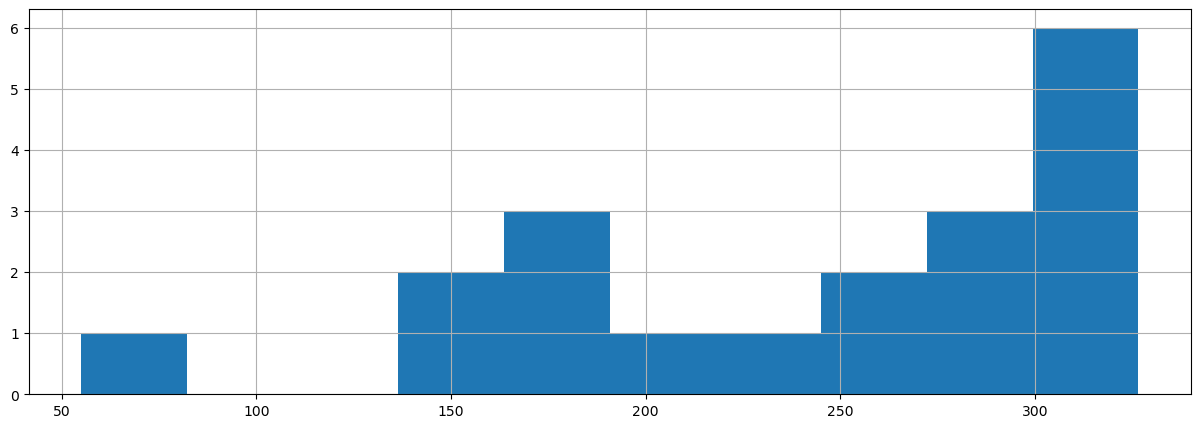

In [30]:
radiation_statistics_df['Radiation_Mean'].hist()

<AxesSubplot:>

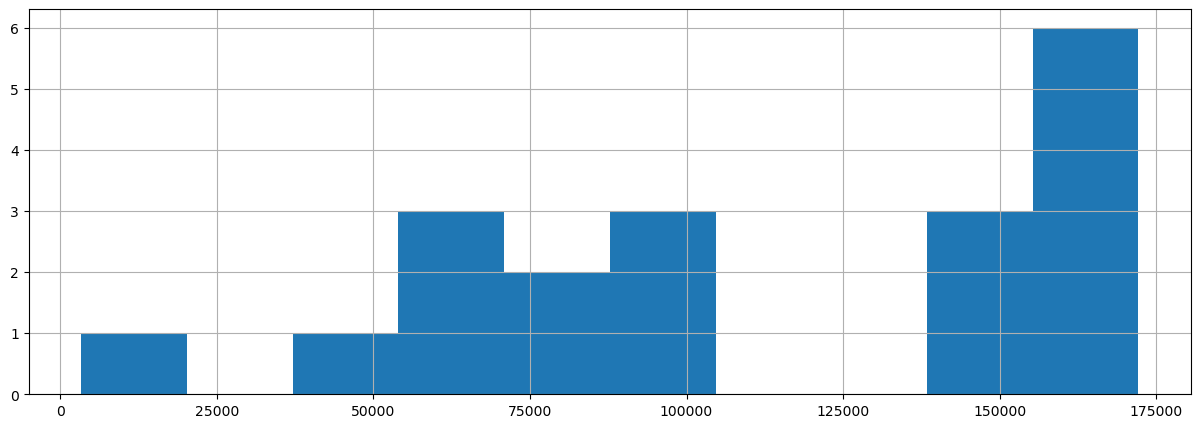

In [31]:
radiation_statistics_df['Radiation_Variance'].hist()

#### Augmented Dickey-Fuller Test

What you need to know:
1. **Null hypothesis:** the series is nonstationary.
2. **Alternative hypothesis:** the series is stationary.

Like any statistical test you should set a significance level or threshold that determines whether you should accept or reject the null.
> The value 0.05 is common but depends upons numerous factors.

In [32]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_radiation_df['Radiation'], regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -10.63729999874085
p-value: 5.0337791233970575e-19


In [33]:
def test_stationarity(df, ts_column):
    # Determining rolling statistics
    rolmean = df[ts_column].rolling(window = 12, center = False).mean()
    rolstd = df[ts_column].rolling(window = 12, center = False).std()

    # Plot rolling statistics:
    orig = plt.plot(df[ts_column], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts_column], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

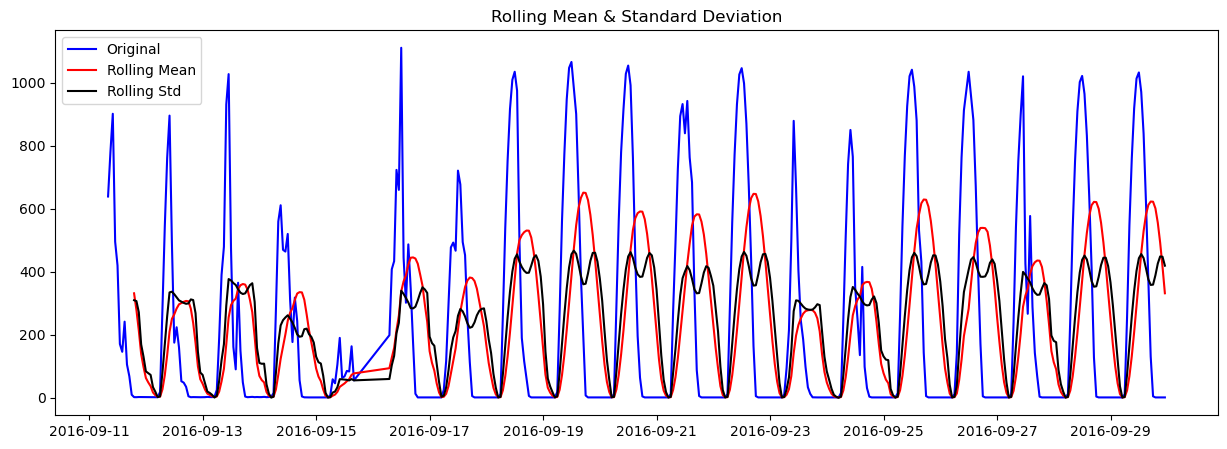

Results of Dickey-Fuller Test:
Test Statistic                -1.063730e+01
p-value                        5.033779e-19
# Lags Used                    1.300000e+01
Number of Observations Used    4.190000e+02
Critical Value (1%)           -3.446054e+00
Critical Value (5%)           -2.868463e+00
Critical Value (10%)          -2.570458e+00
dtype: float64


In [34]:
test_stationarity(hourly_radiation_df, 'Radiation')

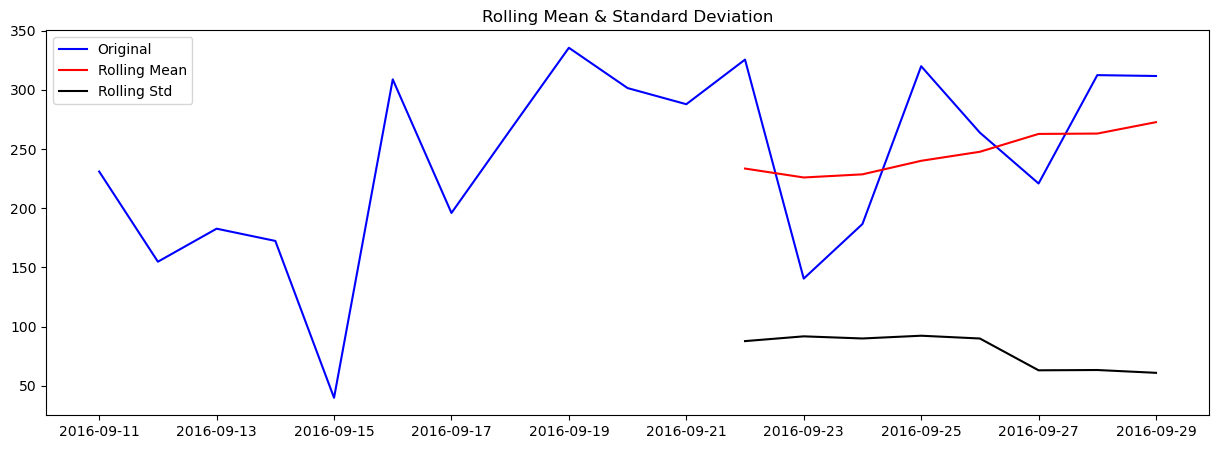

Results of Dickey-Fuller Test:
Test Statistic                 -0.692224
p-value                         0.848753
# Lags Used                     7.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [35]:
test_stationarity(daily_radiation_df, 'Radiation')

#### Explanation (additive hypothesis)

Based on [this resource](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

Based on histograms and augmented Dickey-Fuller test with **p-value < 0.05** we can reject null hypothesis that the time series is non-stationary.
Therefore, our data is **stationary**.

----
It seems that the time series is non-stationary, since we do not have constant mean and variance + for hourly splitted time series there is periodic component. Sync with Andriy about that

### Summary Statistics & Plots (multiplicative hypothesis)

In [36]:
# Compare means and variances
radiation_statistics_df['Log_Radiation_Mean'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Log_Radiation'].mean()
radiation_statistics_df['Log_Radiation_Variance'] = hourly_radiation_df.groupby(['Year', 'Month', 'Day'])['Log_Radiation'].var()

#### Histograms

<AxesSubplot:>

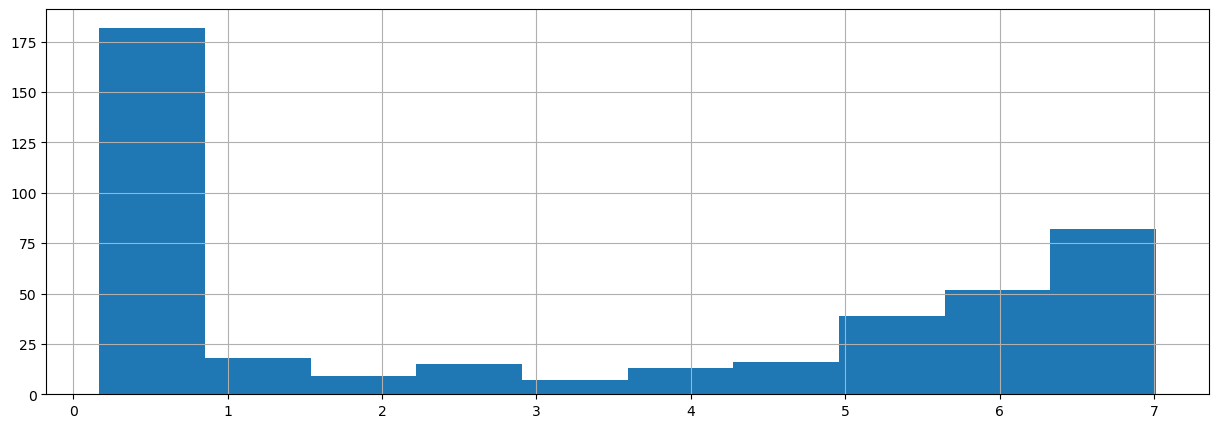

In [37]:
hourly_radiation_df.Log_Radiation.hist()

<AxesSubplot:>

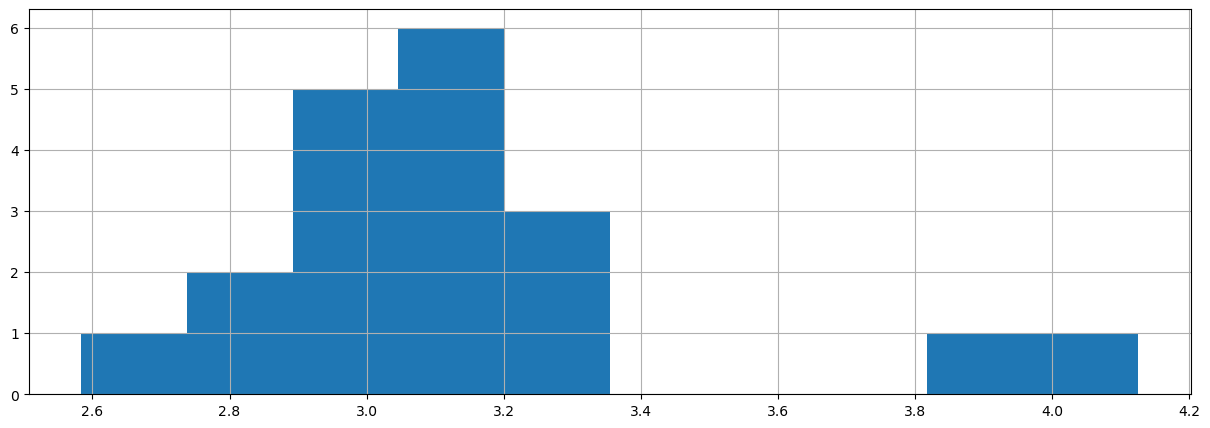

In [38]:
radiation_statistics_df['Log_Radiation_Mean'].hist()

<AxesSubplot:>

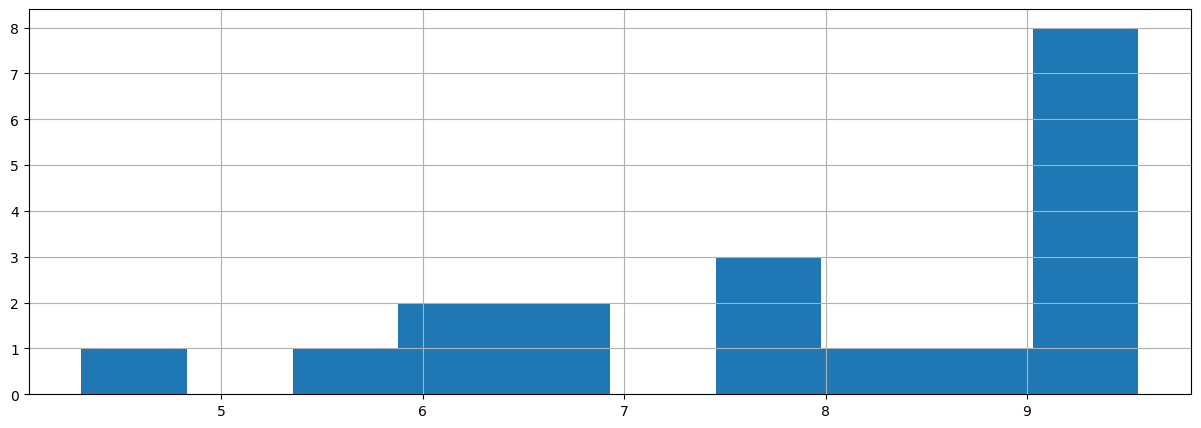

In [39]:
radiation_statistics_df['Log_Radiation_Variance'].hist()

#### Augmented Dickey-Fuller Test

In [40]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(hourly_radiation_df.Log_Radiation, regression='c')
print("ADF: ", adf)
print("p-value:", pvalue)

ADF:  -8.899935811481088
p-value: 1.1788440941281278e-14


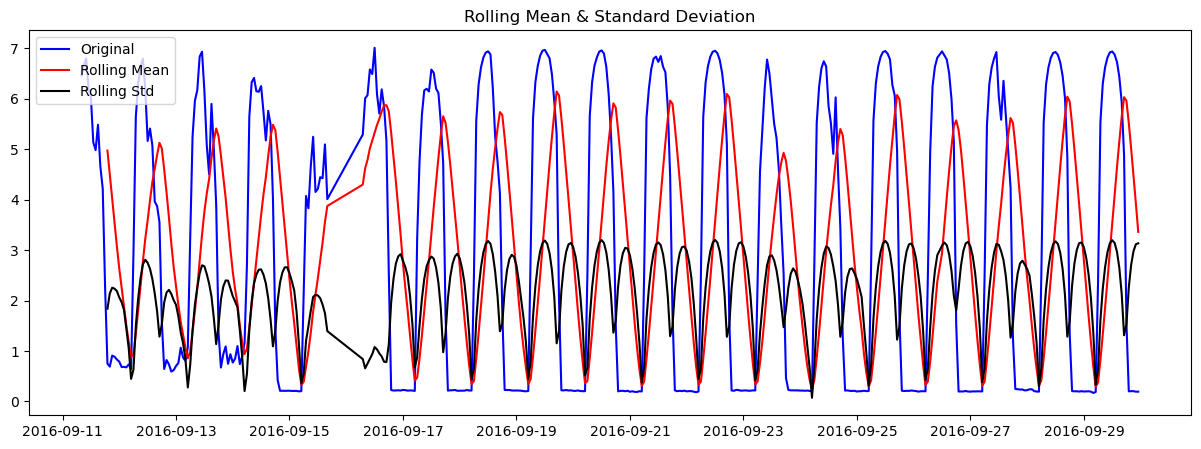

Results of Dickey-Fuller Test:
Test Statistic                -8.899936e+00
p-value                        1.178844e-14
# Lags Used                    1.600000e+01
Number of Observations Used    4.160000e+02
Critical Value (1%)           -3.446168e+00
Critical Value (5%)           -2.868513e+00
Critical Value (10%)          -2.570484e+00
dtype: float64


In [41]:
test_stationarity(hourly_radiation_df, 'Log_Radiation')

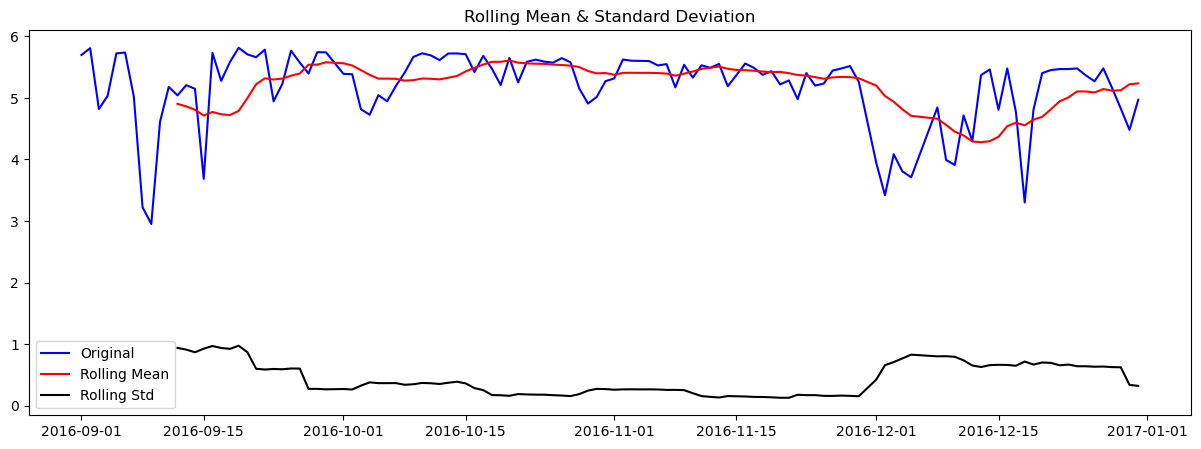

Results of Dickey-Fuller Test:
Test Statistic                  -3.062104
p-value                          0.029488
# Lags Used                      6.000000
Number of Observations Used    111.000000
Critical Value (1%)             -3.490683
Critical Value (5%)             -2.887952
Critical Value (10%)            -2.580857
dtype: float64


In [41]:
test_stationarity(daily_radiation_df, 'Log_Radiation')

#### Explanation (multiplicative hypothesis)

Based on histograms and augmented Dickey-Fuller test with **p-value < 0.05** we can reject null hypothesis that the time series is non-stationary.
Therefore, our data is **stationary**.

<a id='section_3'></a>
## Section 3. Nonstationary-to-Stationary Transformations  ???

Let's create a few stationary time series from our non-stationary ones, to test, which of them will give us the best score.

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


def get_polynomial_trend_prediction(trend):
    X = trend.index[:, np.newaxis]
    y = trend.values[:, np.newaxis]

    poly_reg = PolynomialFeatures(degree=2)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    polynomial_trend_prediction = pol_reg.predict(poly_reg.fit_transform(X))

    # Visualizing the Polymonial Regression results
    plt.scatter(X, y, color='red')
    plt.plot(X, polynomial_trend_prediction, color='blue')
    plt.ylabel('Production')
    plt.show()

    return polynomial_trend_prediction.flatten()

### Approach #1: Remove Trend & Seasonality with Statsmodels

#### Additive hypothesis

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

SHIFT = 6

# ss_decomposition = seasonal_decompose(x=daily_radiation_df.Radiation, model='additive', period=FORECAST_PERIOD)
ss_decomposition = seasonal_decompose(x=hourly_radiation_df.Radiation, model='additive', period=FORECAST_PERIOD)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

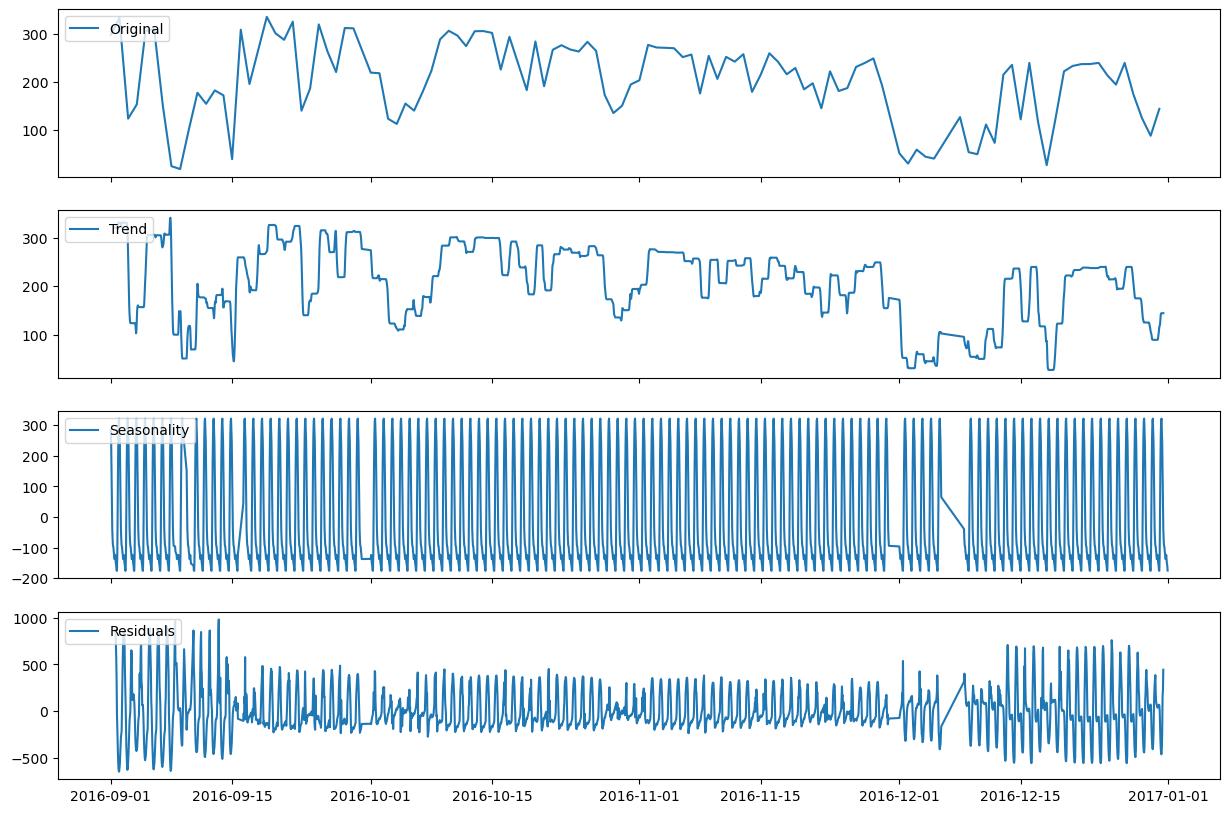

In [43]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(daily_radiation_df.Radiation, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left')

In [45]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual[SHIFT:-SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

additive_decomposed_production = estimated_residual[SHIFT:-SHIFT].reset_index(drop=True)
additive_decomposed_trend = estimated_trend[SHIFT: -SHIFT]
additive_decomposed_seasonal = estimated_seasonal

MissingDataError: exog contains inf or nans

In [ ]:
# predict our trent with polynomial of second degree to use it for forecast on test set
additive_decomposed_trend_prediction = get_polynomial_trend_prediction(additive_decomposed_trend)

#### Multiplicative hypothesis

In [44]:
# used model='multiplicative' to split on trend, seasonal and residuals
ss_decomposition = seasonal_decompose(x=daily_radiation_df.Radiation, model='multiplicative', period=FORECAST_PERIOD)
estimated_trend2 = ss_decomposition.trend
estimated_seasonal2 = ss_decomposition.seasonal
estimated_residual2 = ss_decomposition.resid

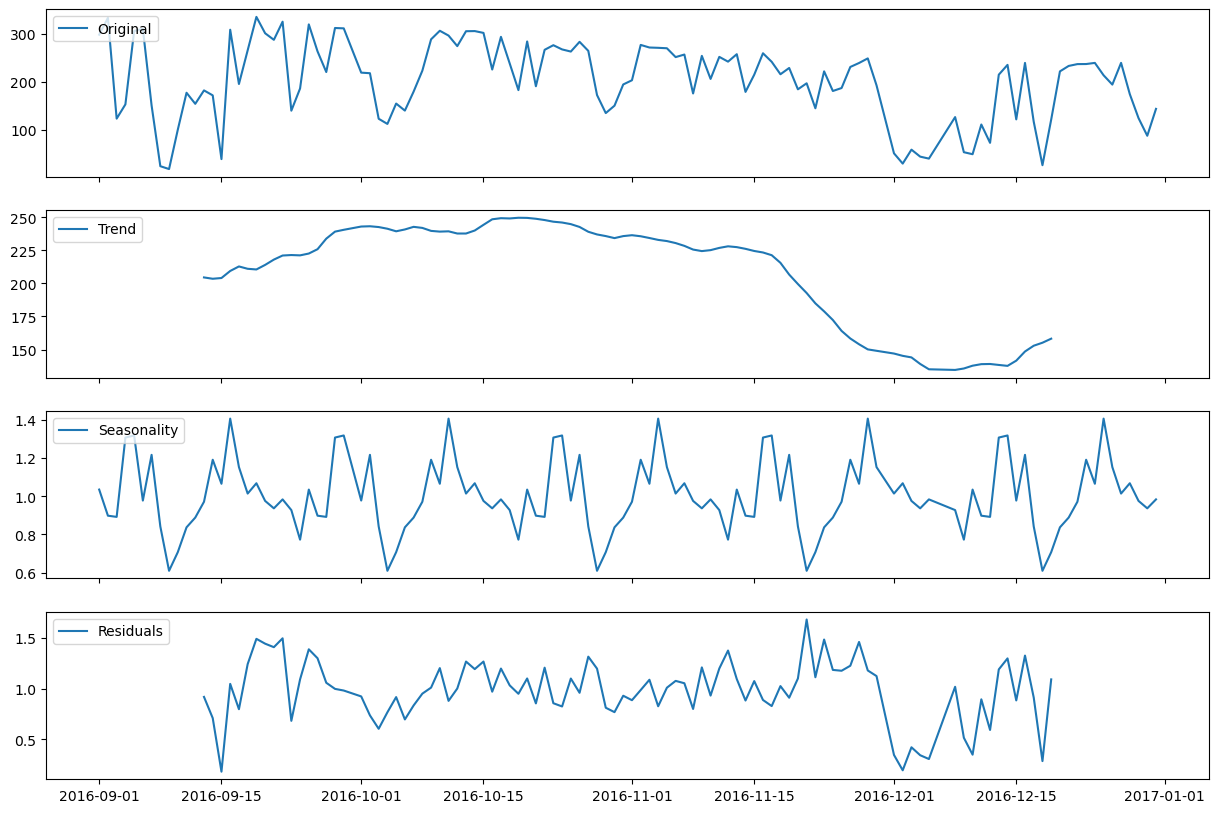

In [45]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(daily_radiation_df.Radiation, label='Original')
axes[0].legend(loc='upper left')

axes[1].plot(estimated_trend2, label='Trend')
axes[1].legend(loc='upper left')

axes[2].plot(estimated_seasonal2, label='Seasonality')
axes[2].legend(loc='upper left')

axes[3].plot(estimated_residual2, label='Residuals')
axes[3].legend(loc='upper left')

In [46]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(estimated_residual2[SHIFT:-SHIFT])
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

multiplicative_decomposed_production = estimated_residual2[SHIFT:-SHIFT].reset_index(drop=True)
multiplicative_decomposed_trend = estimated_trend2[SHIFT: -SHIFT]
multiplicative_decomposed_seasonal = estimated_seasonal2

MissingDataError: exog contains inf or nans

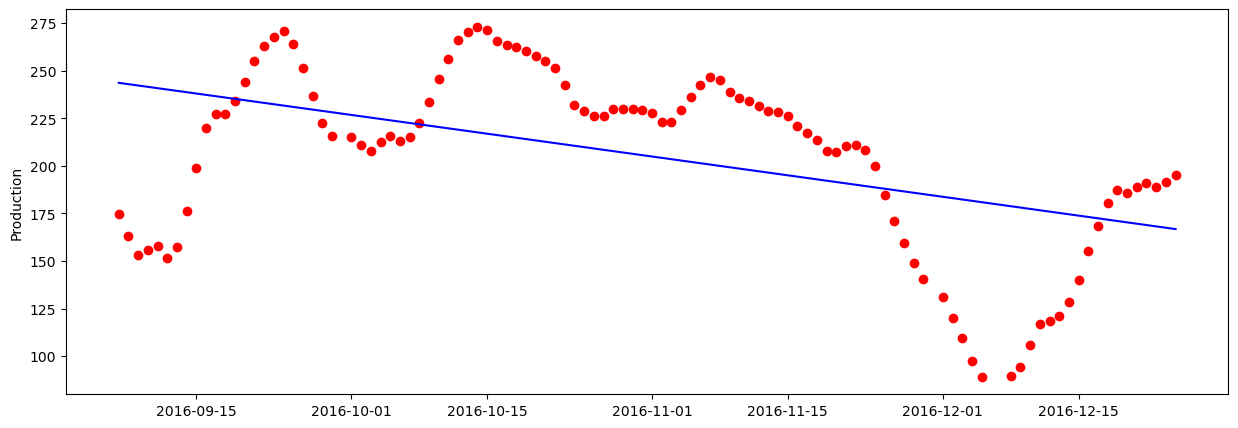

In [242]:
# predict our trent with polynomial of second degree to use it for forecast on test set
multiplicative_decomposed_trend_prediction = get_polynomial_trend_prediction(multiplicative_decomposed_trend)

#### Note!

Now **both additive_decomposed_production and multiplicative_decomposed_production are stationary**, what we can observe from plots of residuals and augmented Dickey-Fuller tests (both p-values < 0.05).

### Approach #2: Log Transformation

As our time series of multiplicative hypothesis was non-stationary, so this approach did not help to make our initial OtherPEN_production['Production'] stationary.

### Approach #3: Removing Autocorrelation with Differencing

Let's subtract $O_{t-1}$ from $O_{t}$ where $O_{t}$ is the observed data at time *t* and $O_{t-1}$ is the observed data at *t-1*.

#### Additive hypothesis

Here ew use differencing approach with lag = 1 (to reduce trend) and lag = 12 (to reduce sessonality).

##### First difference

In [243]:
additive_diff_production_1 = OtherPEN_production['Production'].diff(FORECAST_PERIOD).diff(1)

NameError: name 'OtherPEN_production' is not defined

In [ ]:
run_sequence_plot(OtherPEN_production['Date'], additive_diff_production_1,
                  title="OtherPEN_production After Differencing")

In [ ]:
additive_diff_production_1 = additive_diff_production_1[1 + FORECAST_PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

##### Second difference

In [ ]:
additive_diff_production_12 = OtherPEN_production['Production'].diff(PERIOD)

In [ ]:
run_sequence_plot(OtherPEN_production['Date'], additive_diff_production_12,
                  title="OtherPEN_production After Second Differencing")

In [ ]:
additive_diff_production_12 = additive_diff_production_12[PERIOD:].reset_index(drop=True)

In [ ]:
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(additive_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

#### Multiplicative hypothesis

##### First difference

In [ ]:
multiplicative_diff_production_1 = OtherPEN_production['Log_production'].diff(PERIOD).diff(1)

run_sequence_plot(OtherPEN_production['Date'], multiplicative_diff_production_1,
                  title="Multiplicative OtherPEN_production After First Differencing")

In [ ]:
multiplicative_diff_production_1 = multiplicative_diff_production_1[1 + PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_1)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

##### Second difference

In [ ]:
multiplicative_diff_production_12 = OtherPEN_production['Log_production'].diff(PERIOD)

run_sequence_plot(OtherPEN_production['Date'], multiplicative_diff_production_12,
                  title="Multiplicative OtherPEN_production After Second Differencing")

In [ ]:
multiplicative_diff_production_12 = multiplicative_diff_production_12[PERIOD:].reset_index(drop=True)
adf_after, pvalue_after, usedlag_, nobs_, critical_values_, icbest_ = adfuller(multiplicative_diff_production_12)
print("ADF: ", adf_after)
print("p-value: ", pvalue_after)

In [ ]:
data_to_return_to_initial_series = {
    'additive_decomposed_production': {
        'predicted_trend': additive_decomposed_trend_prediction,
        'seasonality': additive_decomposed_seasonal
    },
    'multiplicative_decomposed_production': {
        'predicted_trend': multiplicative_decomposed_trend_prediction,
        'seasonality': multiplicative_decomposed_seasonal
    },
    'additive_diff_production_1': {
        'lag': 1
    },
    'multiplicative_diff_production_1': {
        'lag': 1
    },
    'additive_diff_production_12': {
        'lag': PERIOD
    },
    'multiplicative_diff_production_12': {
        'lag': PERIOD
    }
}

#### Note!

All our result time series from approach 3 are stationary both for additive and multiplicative hypotheses.

<a id='section_4'></a>
## Section 4. Correlation analysis

In [ ]:
original_df

In [ ]:
# print plots for all columns in area_df
alt.Chart(pd.melt(area_df, "Year")).mark_line()\
    .encode(
    x = alt.X("Year:O"),
    y = alt.Y("value:Q")
).properties(width=800 / 2, height=800 / 4)\
    .facet(
    facet=alt.Facet("variable:N"),
    columns=2
).resolve_scale(y="independent", x="independent")


In [ ]:
OtherPEN_area_df = area_df.where(area_df['Region'] == 'OtherPEN')

# join only OtherPEN df with OtherPEN_area_df to avoid long joins of the initial full dataframes of all regions
OtherPEN_prod_features = pd.merge(OtherPEN_production, OtherPEN_area_df, on=["Year"], how='left')

In [ ]:
rainfall_df.Region.unique()

In [ ]:
# change column value as state name in rainfall_df and OtherPEN_prod_features is different
OtherPEN_prod_features.Region = 'Other Pen. States'

OtherPEN_prod_features = pd.merge(OtherPEN_prod_features, rainfall_df, on=['Year', 'Month', 'Region'], how='left')
OtherPEN_prod_features.drop('Region', inplace=True, axis=1)

for col_name in ['Area_New', 'Area_ma', 'Area_ma_new', 'Area_npa', 'Area_rpa', 'Rainfall']:
    OtherPEN_prod_features[col_name].fillna(OtherPEN_prod_features[col_name].mean(), inplace=True)

OtherPEN_prod_features

In [ ]:
# hourly_radiation_df['Hourly_DateTime'] = hourly_radiation_df.index
hourly_radiation_df.head()

In [ ]:
sns.pairplot(hourly_radiation_df,
             x_vars=['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Month', 'Day_of_week', 'Weekend'],
             y_vars=['Radiation'],
             # hue='Hourly_DateTime'
             hue='Day'
             )

From the below analysis we can choose the best features which we can use for our DL and ML models. In my case this are **Area_npa** and **Area_ma**

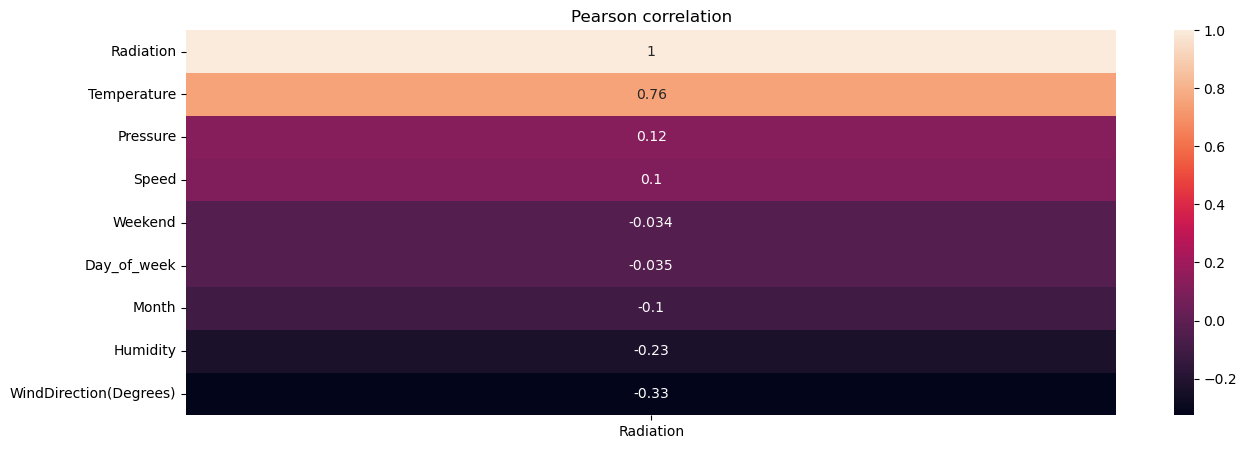

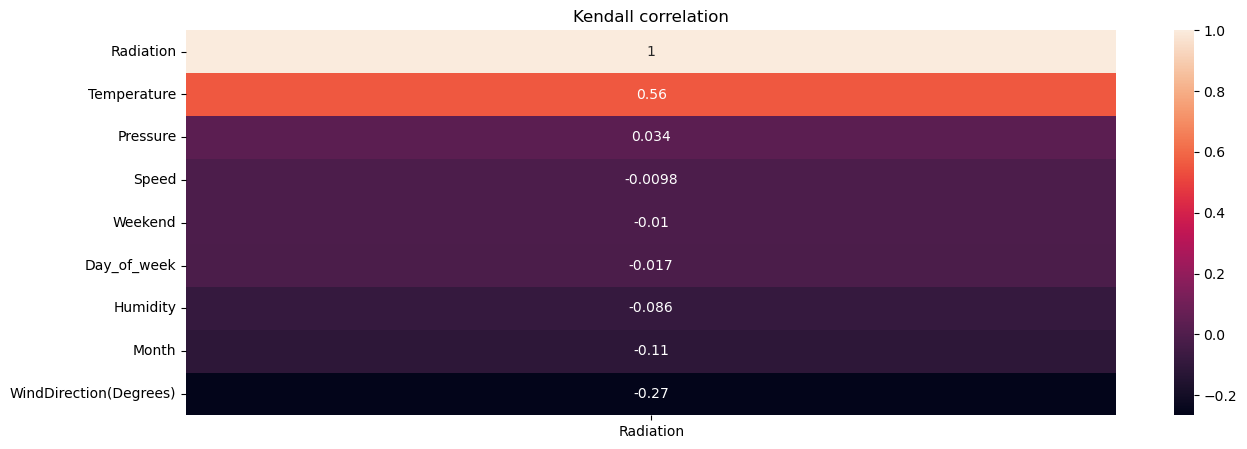

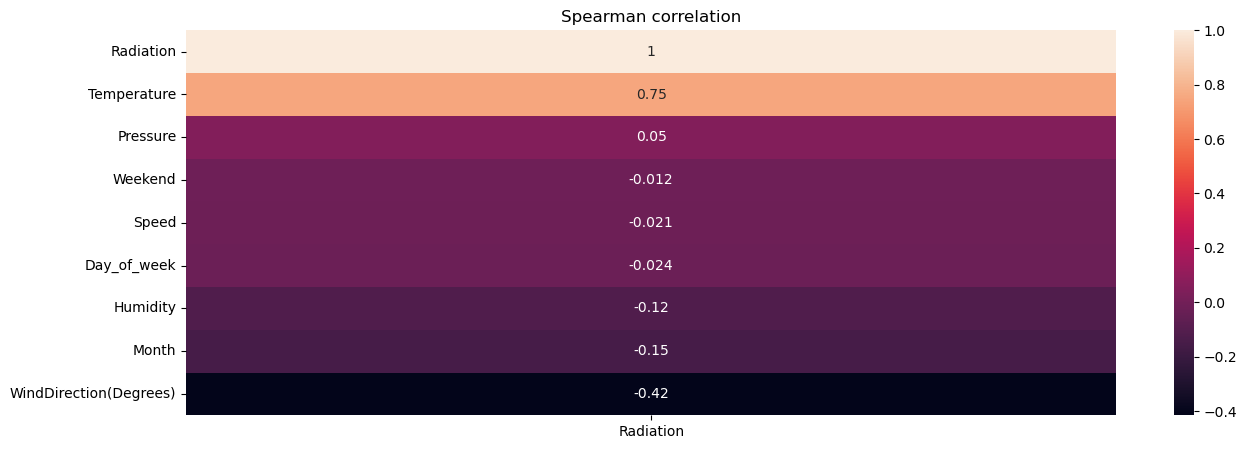

In [244]:
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        hourly_radiation_df[['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Month', 'Day_of_week', 'Weekend']]
            .corr(method=method)[['Radiation']]\
            .sort_values(by='Radiation', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()

<a id='section_5'></a>
## Section 5. Feature generation and validation of DL models

In [26]:
import statsmodels.tsa.api as smt


def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5  # RMSE

    return({'1. Mean Absolute Percentage Error (MAPE)':mape,
            '2. Mean Percentage Error (MPE)': mpe,
            '3. Root Mean Squared Error (RMSE)': rmse})


def plots(data, lags=None):
    # define helper plot function for visualization
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [43]:
"""
def get_train_validation_test_split(time_series):
    "

    :return: splits on train, validation and test sets based on Cross-Validation
    "
    n_splits = 3 #Number of train/cv/test folds
    results = []

    trainTestSplit = TimeSeriesSplit(n_splits+1, test_size=12).split(time_series)
    next(trainTestSplit) #Skip the first fold

    for trainCvIndices, testIndices in trainTestSplit:
        # First, we split Train + CV and Test
        XTrainCv = time_series.iloc[trainCvIndices]
        XTest = time_series.iloc[testIndices]

        # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
        testLength = len(XTest)
        train = XTrainCv.iloc[0: -testLength]
        validate = XTrainCv.iloc[-testLength: ]

        results.append([train, validate, XTest, XTrainCv])

    return results
"""


'\ndef get_train_validation_test_split(time_series):\n    "\n\n    :return: splits on train, validation and test sets based on Cross-Validation\n    "\n    n_splits = 3 #Number of train/cv/test folds\n    results = []\n\n    trainTestSplit = TimeSeriesSplit(n_splits+1, test_size=12).split(time_series)\n    next(trainTestSplit) #Skip the first fold\n\n    for trainCvIndices, testIndices in trainTestSplit:\n        # First, we split Train + CV and Test\n        XTrainCv = time_series.iloc[trainCvIndices]\n        XTest = time_series.iloc[testIndices]\n\n        # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]\n        testLength = len(XTest)\n        train = XTrainCv.iloc[0: -testLength]\n        validate = XTrainCv.iloc[-testLength: ]\n\n        results.append([train, validate, XTest, XTrainCv])\n\n    return results\n'

In [44]:
def return_to_initial_series_additive_differencing(best_ARMA_model_prediction, len_train_set, params_tpl, stationary_series_name,
                                                   model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD
    lag = data_to_return_to_initial_series[stationary_series_name]['lag']

    best_ARMA_model_prediction = best_ARMA_model_prediction.reset_index(drop=True)
    ARMA_model_prediction_initial_series = []

    for i in range(lag):
        ARMA_model_prediction_initial_series.append(OtherPEN_production.Production[len_train_set - lag + i + SHIFT] + best_ARMA_model_prediction[i])

    for i in range(lag, len(best_ARMA_model_prediction)):
        ARMA_model_prediction_initial_series.append(ARMA_model_prediction_initial_series[i - lag] +
                                                    best_ARMA_model_prediction[i])

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    model_forecast_accuracy = forecast_accuracy(ARMA_model_prediction_initial_series,
                                                OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT].to_numpy())
    print('Params -- ', params_tpl)
    pprint(model_forecast_accuracy)

    if show_plots:
        x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

        # add + 1 to make consistent plot
        plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], 'b--', label="train")
        plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', linestyle="--", label="test")
        plt.plot(x_indices, ARMA_model_prediction_initial_series, 'r--', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {params_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return ARMA_model_prediction_initial_series, model_forecast_accuracy


def return_to_initial_series_decomposed(best_model_prediction, len_train_set, params_tpl, stationary_series_name,
                                                 model_name, show_plots):
    start_idx = len_train_set
    end_idx = len_train_set + FORECAST_PERIOD

    if 'additive' in stationary_series_name:
        model_prediction_initial_series = best_model_prediction +\
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + SHIFT: end_idx + SHIFT].values +\
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]
    else:
        model_prediction_initial_series = best_model_prediction *\
                                               data_to_return_to_initial_series[stationary_series_name]['seasonality'][start_idx + SHIFT: end_idx + SHIFT].values *\
                                               data_to_return_to_initial_series[stationary_series_name]['predicted_trend'][start_idx: end_idx]

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    model_forecast_accuracy = forecast_accuracy(model_prediction_initial_series,
                                                OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT].to_numpy())
    print('Params -- ', params_tpl)
    pprint(model_forecast_accuracy)

    if show_plots:
        x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

        # add + 1 to make consistent plot
        plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], color='blue', label="train")
        plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
        plt.plot(x_indices, model_prediction_initial_series, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} {params_tpl} Prediction on Test Dataset')
        plt.grid(alpha=0.3)
        plt.show()

    return model_prediction_initial_series, model_forecast_accuracy

In [27]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape
    [n_samples, time_steps, features]
    """

    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)


In [28]:
"""REGIONS = [['JH', 'Johor', 'JH'],
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'],
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]"""

"REGIONS = [['JH', 'Johor', 'JH'],\n           ['PH', 'Pahang', 'PH'],\n           ['PRK', 'Perak', 'PRK'],\n           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],\n           ['PEN', 'Peninsula', 'Pmalay'],\n           ['SBH', 'Sabah', 'SBH'],\n           ['SWK', 'Sarawak', 'SWK']]"

In [29]:
hourly_radiation_df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Sun_Day_Duration,Year,Month,Day,Hour,Day_of_week,Weekend,Log_Radiation
Hourly_DateTime,,,,,,,,,,,,,,
2016-09-11 08:00:00,638.927500,58.250000,30.490000,48.000000,198.712500,4.215000,12.33,2016,9,11,8,6,1,6.459791
2016-09-11 09:00:00,779.866667,59.166667,30.500000,59.500000,53.563333,4.684167,12.33,2016,9,11,9,6,1,6.659123
2016-09-11 10:00:00,901.528333,60.500000,30.500000,74.250000,50.269167,7.310000,12.33,2016,9,11,10,6,1,6.804091
2016-09-11 11:00:00,495.330909,60.636364,30.495455,77.454545,127.091818,6.030909,12.33,2016,9,11,11,6,1,6.205226
2016-09-11 12:00:00,420.120833,60.500000,30.478333,81.083333,34.070000,6.372500,12.33,2016,9,11,12,6,1,6.040542


In [44]:
def process_data(df, stationary_series, features_lags, radiation_lags, recent_radiation_lags):
    features_df = df.copy()
    features_df.drop(['Year', 'Day', 'Sun_Day_Duration',
                      'Month', 'Day_of_week', 'Weekend',  # we do not have data for the whole year, hence we need to drop 'Month' column
                      'Hour', 'Log_Radiation'], axis=1, inplace=True)
    feature_columns = ['Temperature', 'Pressure', 'Humidity',
                       'WindDirection(Degrees)', 'Speed']

    for feature_column_name in feature_columns:
        for lag in features_lags:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df[feature_column_name].values[:-lag]))
            features_df[f'{feature_column_name}_lag_{lag}'] = temp

    for lag in radiation_lags:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df['Radiation'].values[:-lag]))
        features_df[f'Radiation_lag_{lag}'] = temp

    for lag in recent_radiation_lags:
        temp = np.concatenate((np.array([np.nan for _ in range(lag)]), features_df['Radiation'].values[:-lag]))
        features_df[f'Radiation_lag_{lag}'] = temp

    features_df.fillna(features_df.mean(), inplace=True)

    # And finally drop rainfalls
    features_df.drop(feature_columns, axis=1, inplace=True)
    features_df.drop(['Radiation'], axis=1, inplace=True)

    return (features_df[max(features_lags + radiation_lags):], stationary_series[max(features_lags + radiation_lags):])

In [45]:
process_data(hourly_radiation_df, hourly_radiation_df.Radiation, FEATURES_LAGS, RADIATION_LAGS, RECENT_RADIATION_LAGS)[0].head()

,Temperature_lag_24,Temperature_lag_48,Temperature_lag_72,Temperature_lag_96,Temperature_lag_120,Pressure_lag_24,Pressure_lag_48,Pressure_lag_72,Pressure_lag_96,Pressure_lag_120,...,Radiation_lag_24,Radiation_lag_48,Radiation_lag_72,Radiation_lag_96,Radiation_lag_120,Radiation_lag_1,Radiation_lag_2,Radiation_lag_3,Radiation_lag_4,Radiation_lag_5
Hourly_DateTime,,,,,,,,,,,,,,,,,,,,,
2016-09-16 22:00:00,50.250000,55.750000,58.916667,59.090909,58.250000,30.453333,30.442500,30.460000,30.508182,30.490000,...,46.076667,559.531667,389.909167,544.880909,638.927500,1.242500,1.241667,1.252500,12.866667,176.119167
2016-09-16 23:00:00,51.416667,59.000000,60.333333,61.583333,59.166667,30.468333,30.453333,30.470000,30.517500,30.500000,...,105.800000,611.165833,479.270000,761.504167,779.866667,1.247500,1.242500,1.241667,1.252500,12.866667
2016-09-17 00:00:00,53.625000,57.916667,63.333333,64.666667,60.500000,30.467500,30.465833,30.470000,30.520833,30.500000,...,190.196250,469.695000,931.430000,895.710000,901.528333,1.240833,1.247500,1.242500,1.241667,1.252500
2016-09-17 01:00:00,54.666667,59.166667,66.818182,64.833333,60.636364,30.466667,30.455833,30.460000,30.514167,30.495455,...,63.700000,464.182500,1027.411818,492.608333,495.330909,1.256250,1.240833,1.247500,1.242500,1.241667
2016-09-17 02:00:00,54.000000,63.500000,64.416667,61.909091,60.500000,30.460000,30.441667,30.444167,30.497273,30.478333,...,67.750000,520.101667,474.395833,175.143636,420.120833,1.250833,1.256250,1.240833,1.247500,1.242500


### Fit DL models

In [46]:
def fit_SimpleRNN_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit SimpleRNN to data train_X, train_y with features

    """
    hidden_units, batch_size, epochs = params

    # initialize model
    model = Sequential()

    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(SimpleRNN(hidden_units, input_shape=(train_X.shape[1], 1)))
    model.add(Dropout(0.2))

    # add an output layer to make final predictions
    model.add(Dense(1, activation='relu'))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        history = model.fit(train_X, train_y,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(validate_X, validate_y),
                            verbose=0, shuffle=False)

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model.fit(train_X, train_y,
                    epochs=epochs, batch_size=batch_size,
                    verbose=0, shuffle=False)

    return model


def fit_LSTM_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit LSTM to data train_X, train_y

    """
    hidden_units, batch_size, epochs = params

    model = Sequential()
    print('train_X.shape[1] -- ', train_X.shape[1])
    print('train_X.shape[2] -- ', train_X.shape[2])
    model.add(LSTM(hidden_units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = model.fit(train_X, train_y,
                            epochs=epochs, batch_size=batch_size,
                            validation_data=(validate_X, validate_y),
                            verbose=0, shuffle=False,
                            callbacks=[tensorboard_callback])

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'][1:])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model.fit(train_X, train_y,
                      epochs=epochs, batch_size=batch_size,
                      verbose=0, shuffle=False)

    return model


In [47]:
def fit_Conv1d_features(train_X, train_y, validate_X, validate_y, params, is_test_model):
    """

    Fit Conv1d to data train_X, train_y

    """
    filters, batch_size, epochs = params
    optimizer = Adagrad(0.01)

    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=filters, kernel_size=2, activation='relu',
                         input_shape=(train_X.shape[1], train_X.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(50, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mse', optimizer=optimizer)

    # fit network
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    if is_test_model == False:
        history = model_cnn.fit(train_X, train_y,
                                epochs=epochs, batch_size=batch_size,
                                validation_data=(validate_X, validate_y),
                                verbose=0, shuffle=False)

        # get the lowest validation loss of the training epochs
        validation_loss = np.amin(history.history['val_loss'][1:])
        print('Best validation loss of epoch:', validation_loss)

    else:
        model_cnn.fit(train_X, train_y,
                      epochs=epochs, batch_size=batch_size,
                      verbose=0, shuffle=False)

    return model_cnn


In [48]:
def get_train_validation_test_splits(np_array):
    # end_shift = max(FEATURES_LAGS + RADIATION_LAGS)
    # train_lengths = [177 - end_shift, 189 - end_shift, 201 - end_shift]
    df_length = np_array.shape[0]
    print('df_length -- ', df_length)
    validate_length = FORECAST_PERIOD # also equal to test length
    train_lengths = [df_length - 4 * validate_length, df_length - 3 * validate_length, df_length - 2 * validate_length]

    splits = []
    for train_length in train_lengths:
        train = np_array[: train_length, :]
        validate = np_array[train_length: train_length + validate_length, :]
        train_validate = np_array[:train_length + validate_length, :]
        test = np_array[train_length + validate_length: train_length + 2 * validate_length, :]

        splits.append((train, validate, test, train_validate))

    return splits

In [49]:
def reshape_for_model(model_name, dataset):
    if 'LSTM' in model_name or\
        'RNN' in model_name or\
        'Conv1d' in model_name:

        if 'LSTM' in model_name:
            # reshape input to be 3D [samples, features, timesteps]
            dataset = dataset.reshape((dataset.shape[0], 1, dataset.shape[1]))

        else:
            # reshape input to be 3D [samples, timesteps, features]
            dataset = dataset.reshape((dataset.shape[0], dataset.shape[1], 1))

    return dataset


def reshape_test_set_for_model(model_name, test_X):
    if 'LSTM' in model_name or\
        'RNN' in model_name or\
        'Conv1d' in model_name:

        if 'LSTM' in model_name:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
        else:
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

    return test_X


def test_model_with_transform(model, test_X, model_name, first_row_idx):
    """

    Use previous predicted value to construct our feature dataframe and use it for next value prediction
    """
    yhat = []

    test_X = reshape_test_set_for_model(model_name, test_X)

    # Take first row for which we start to forecast.
    # Note that first_row_idx param can be also not equal to zero,
    # for example, it can also be the last index in test_X
    test_row = test_X[first_row_idx]
    prod_lags = test_row[-len(RECENT_RADIATION_LAGS):]
    test_row = test_row.reshape((1, len(test_row)))
    test_row = reshape_for_model(model_name, test_row)
    for i in range(len(test_X)):
        yhat_one_pred = model.predict(test_row)
        yhat.append(yhat_one_pred[0])
        
        test_row = test_X[i]

        prod_lags = np.roll(prod_lags, 1)
        prod_lags[0] = yhat_one_pred
        new_test_row = np.concatenate((test_row[:-len(RECENT_RADIATION_LAGS)], prod_lags), axis=0)
        # new_test_row = np.concatenate((test_row[:-len(STATIONARY_PRODUCTION_LAGS)], prod_lags), axis=0)
        test_row = new_test_row.reshape((1, len(new_test_row)))
        test_row = reshape_for_model(model_name, test_row)
    
    yhat = np.array(yhat)
    yhat[yhat<0] = 0
    return yhat


In [50]:
def optimize_DL_feature_models(params_list, stationary_series_name, model_name, full_df_split, SCALER, show_plots, debug_mode):
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 100_000
    best_model = dict()

    train, validate, test, train_validate = full_df_split

    train_X, train_y = train[:, :-1], train[:, -1]
    validate_X, validate_y = validate[:, :-1], validate[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_validate_X, train_validate_y = train_validate[:, :-1], train_validate[:, -1]

    if 'LSTM' in model_name:
        # reshape input to be 3D [samples, features, timesteps]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        validate_X = validate_X.reshape((validate_X.shape[0], 1, validate_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        train_validate_X = train_validate_X.reshape((train_validate_X.shape[0], 1, train_validate_X.shape[1]))

    else:
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
        validate_X = validate_X.reshape((validate_X.shape[0], validate_X.shape[1], 1))
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
        train_validate_X = train_validate_X.reshape((train_validate_X.shape[0], train_validate_X.shape[1], 1))

    # find the best params for the model based on validation set
    best_model['params'] = params_list[0]
    for params in params_list:
        if 'Conv1d' in model_name:
            model = fit_Conv1d_features(train_X, train_y, validate_X, validate_y, params, False)
        elif 'LSTM' in model_name:
            print('train_X', train_X[:5])
            print('train_y', train_y[:5])
            print('validate_X', validate_X[:5])
            print('validate_y', validate_y[:5])
            model = fit_LSTM_features(train_X, train_y, validate_X, validate_y, params, False)
        else:
            model = fit_SimpleRNN_features(train_X, train_y, validate_X, validate_y, params, False)

        yhat = test_model_with_transform(model, validate_X, model_name, 0)
        model_forecast_accuracy = forecast_accuracy(yhat, validate_y)
        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Params -- ', params)
            pprint(model_forecast_accuracy)

        # weighted_score
        weighted_score = 0.5 * (model_forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (model_forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['params'] = params
            best_model['prediction'] = yhat
            best_model['model_accuracy'] = model_forecast_accuracy

    # make a prediction
    if 'LSTM' in model_name:
        test_model = fit_LSTM_features(train_validate_X, train_validate_y, None, None, best_model['params'], True)
        yhat = test_model_with_transform(test_model, test_X, model_name, 0)
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    else:
        if 'Conv1d' in model_name:
            test_model = fit_Conv1d_features(train_validate_X, train_validate_y, None, None, best_model['params'], True)
        else:
            test_model = fit_SimpleRNN_features(train_validate_X, train_validate_y, None, None, best_model['params'], True)

        yhat = test_model_with_transform(test_model, test_X, model_name, 0)
        test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))

    if show_plots:
        plt.plot(test_y, color='orange', label="test")
        plt.plot(yhat, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} on TEST set with params -- {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, yhat), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # return to initial series
    best_model_test_accuracy = dict()
    best_model_prediction_initial_series = []
    if 'decomposed' in stationary_series_name:
        best_model_prediction_initial_series, best_model_test_accuracy =\
            return_to_initial_series_decomposed(inv_yhat, len(train_validate_y) + MAX_DF_SHIFT, best_model['params'],
                                                stationary_series_name, model_name, show_plots)

    else:
        best_model_prediction_initial_series = inv_yhat
        best_model_test_accuracy = forecast_accuracy(yhat, test_y)

    # In this lab I decided to stay decomposed stationary series as they showed the best performance during my testing and
    # also them showed the best performance for HW_1. In such a way I also reduce time to run this notebok by yourself.
    # else:
    #     if 'multiplicative' in stationary_series_name:
    #         inv_yhat = np.exp(inv_yhat)
    #
    #     best_model_prediction_initial_series, best_model_test_accuracy =\
    #         return_to_initial_series_additive_differencing(inv_yhat, len(train_validate_y) + MAX_DF_SHIFT, best_model['params'],
    #                                                        stationary_series_name, model_name, show_plots)

    return best_model_prediction_initial_series, best_model['params'], best_model_test_accuracy


In [51]:
def fit_Random_Forest(params):
    model = RandomForestRegressor(
        n_estimators=params[0],
        max_depth=params[1],
        random_state=0
    )
    return model


def fit_XGBoost(params):
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=params[0],
        max_depth=params[1],
        min_child_weight=params[2]
    )
    return model

In [52]:
def optimize_ML_feature_models(params_list, stationary_series_name, model_name, full_df_split, SCALER, show_plots, debug_mode):
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 100_000
    best_model = dict()

    train, validate, test, train_validate = full_df_split

    train_X, train_y = train[:, :-1], train[:, -1]
    validate_X, validate_y = validate[:, :-1], validate[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_validate_X, train_validate_y = train_validate[:, :-1], train_validate[:, -1]

    # find the best params for the model based on validation set
    best_model['params'] = params_list[0]
    for params in params_list:
        if 'Random Forest' in model_name:
            model = fit_Random_Forest(params)
        else:
            model = fit_XGBoost(params)

        model.fit(train_X, train_y)
        yhat = test_model_with_transform(model, validate_X, model_name, 0)
        yhat_2D = yhat[:, np.newaxis]
        model_forecast_accuracy = forecast_accuracy(yhat_2D, validate_y)
        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Params -- ', params)
            pprint(model_forecast_accuracy)

        # weighted_score
        weighted_score = 0.5 * (model_forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (model_forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['params'] = params
            best_model['prediction'] = yhat
            best_model['model_accuracy'] = model_forecast_accuracy

    # make a prediction
    if 'Random Forest' in model_name:
        test_model = fit_Random_Forest(best_model['params'])
    else:
        test_model = fit_XGBoost(best_model['params'])

    test_model.fit(train_validate_X, train_validate_y)
    yhat = test_model_with_transform(test_model, test_X, model_name, 0)

    if show_plots:
        plt.plot(test_y, color='orange', label="test")
        plt.plot(yhat, color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} on TEST set with params -- {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # invert scaling for forecast
    yhat_2D = yhat[:, np.newaxis]
    inv_yhat = np.concatenate((test_X, yhat_2D), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    # return to initial series
    best_model_test_accuracy = dict()
    best_model_prediction_initial_series = []
    if 'decomposed' in stationary_series_name:
        best_model_prediction_initial_series, best_model_test_accuracy =\
            return_to_initial_series_decomposed(inv_yhat, len(train_validate_y) + MAX_DF_SHIFT, best_model['params'],
                                                stationary_series_name, model_name, show_plots)

    return best_model_prediction_initial_series, best_model['params'], best_model_test_accuracy


In [68]:
def get_best_DL_model(stationary_series_name, full_df_split, SCALER, show_plots, debug_mode):
    # # RF_n_estimators = [100, 500, 1000]
    # # RF_max_depth = [80, 90, 100]
    # # RF_params = [RF_n_estimators, RF_max_depth]
    # # RF_params = list(itertools.product(*RF_params))
    #
    # # !!!! you can uncomment previous line and commend the next line for params validation,
    # # but for reducing time to run this notebook by youself I stayed only the best parameters
    # RF_params = [[100, 100], [1000, 100]]
    # best_RF_model_prediction, RF_model_description, RF_forecast_accuracy = optimize_ML_feature_models(RF_params, stationary_series_name,
    #                                                                                                      'Random Forest features', full_df_split, SCALER,
    #                                                                                                      show_plots, debug_mode)
    #
    # # XGB_n_estimators = [100, 500, 1000]
    # # XGB_max_depth = [4, 5, 6]
    # # XGB_min_child_weight = [1, 2, 4]
    # # XGB_params = [XGB_n_estimators, XGB_max_depth, XGB_min_child_weight]
    # # XGB_params = list(itertools.product(*XGB_params))
    # XGB_params = [[100, 4, 1]]
    # best_XGB_model_prediction, XGB_model_description, XGB_forecast_accuracy = optimize_ML_feature_models(XGB_params, stationary_series_name,
    #                                                                                                      'XGBoost features', full_df_split, SCALER,
    #                                                                                                      show_plots, debug_mode)
    #
    # # RNN_filters_lst = [20, 30, 40]
    # # RNN_batch_size_lst = [12, 32, 64]
    # # RNN_epochs_lst = [400]
    # # RNN_params = [RNN_filters_lst, RNN_batch_size_lst, RNN_epochs_lst]
    # # RNN_params = list(itertools.product(*RNN_params))
    # RNN_params = [[20, 32, 400]] # best
    #
    # best_RNN_model_prediction, RNN_model_description, RNN_forecast_accuracy = optimize_DL_feature_models(RNN_params, stationary_series_name,
    #                                                                                                       'RNN features', full_df_split, SCALER,
    #                                                                                                      show_plots, debug_mode)

    # LSTM_units_lst = [20, 30, 40]
    # LSTM_batch_size_lst = [12, 32, 64]
    # LSTM_epochs_lst = [400]
    # LSTM_params = [LSTM_units_lst, LSTM_batch_size_lst, LSTM_epochs_lst]
    # LSTM_params = list(itertools.product(*LSTM_params))
    # LSTM_params = [[20, 12, 400]]
    LSTM_params = [[20, 12, 10]]

    best_LSTM_model_prediction, LSTM_model_description, LSTM_forecast_accuracy = optimize_DL_feature_models(LSTM_params, stationary_series_name,
                                                                                                            'LSTM features', full_df_split, SCALER,
                                                                                                             show_plots, debug_mode)

    # # Conv1d_filters_lst = [20, 30, 40]
    # # Conv1d_batch_size_lst = [12, 32, 64]
    # # Conv1d_epochs_lst = [400]
    # # Conv1d_params = [Conv1d_filters_lst, Conv1d_batch_size_lst, Conv1d_epochs_lst]
    # # Conv1d_params = list(itertools.product(*Conv1d_params))
    # Conv1d_params = [[20, 12, 400], [30, 64, 400]]
    #
    # best_Conv1d_model_prediction, Conv1d_model_description, Conv1d_forecast_accuracy = optimize_DL_feature_models(Conv1d_params, stationary_series_name,
    #                                                                                                               'Conv1d features', full_df_split, SCALER,
    #                                                                                                               show_plots, debug_mode)

    best_model = {'model_name': None, 'model_prediction': None, 'params': None}
    min_weighted_score = 10_000_000
    for forecast_accuracy, model_name, model_prediction, model_description in\
            [
                # (RF_forecast_accuracy, 'Random Forest', best_RF_model_prediction, RF_model_description),
                # (XGB_forecast_accuracy, 'XGBoost', best_XGB_model_prediction, XGB_model_description),
                # (RNN_forecast_accuracy, 'SimpleRNN', best_RNN_model_prediction, RNN_model_description),
                (LSTM_forecast_accuracy, 'LSTM', best_LSTM_model_prediction, LSTM_model_description),
                # (Conv1d_forecast_accuracy, 'Conv1d model', best_Conv1d_model_prediction, Conv1d_model_description),
            ]:
        weighted_score = 0.5 * (forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        print('weighted_score -- ', weighted_score)
        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['model_name'] = model_name
            best_model['model_prediction'] = model_prediction
            best_model['params'] = model_description

            best_model['1. Mean Absolute Percentage Error (MAPE)'] = forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)']
            best_model['2. Mean Percentage Error (MPE)'] = forecast_accuracy['2. Mean Percentage Error (MPE)']
            best_model['3. Root Mean Squared Error (RMSE)'] = forecast_accuracy['3. Root Mean Squared Error (RMSE)']

    return best_model, len(full_df_split[3]) + MAX_DF_SHIFT


In [69]:
def create_feature_df_for_stationary(df, stationary_series):
    data = process_data(df, stationary_series, FEATURES_LAGS, RADIATION_LAGS, RECENT_RADIATION_LAGS)
    processed_df_values = np.concatenate((data[0].values, data[1].values.reshape((-1, 1))), axis=1)
    SCALER = MinMaxScaler(feature_range=(0, 1))
    scaled_df_values = SCALER.fit_transform(processed_df_values)

    return scaled_df_values, SCALER


In [70]:
def test_ML_DL_models(df, stationary_series, stationary_series_name, show_plots, debug_mode):
    full_numpy_arrs, SCALER = create_feature_df_for_stationary(df, stationary_series)
    full_df_splits = get_train_validation_test_splits(full_numpy_arrs)

    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Params',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    for i in range(3):
        full_df_split = full_df_splits[i]
        # print('Train length -- ', full_df_split[0].shape)
        # print('Validation length -- ', full_df_split[1].shape)
        # print('Test length -- ', full_df_split[2].shape)
        # print('TrainCv length -- ', full_df_split[3].shape)

        best_model, last_train_set_idx = get_best_DL_model(stationary_series_name, full_df_split, SCALER, show_plots, debug_mode)
        results_df.loc[i] = [i + 1, stationary_series_name,
                             best_model['model_name'], best_model['params'],
                             best_model['1. Mean Absolute Percentage Error (MAPE)'],
                             best_model['2. Mean Percentage Error (MPE)'],
                             best_model['3. Root Mean Squared Error (RMSE)']]

        # TODO: in progress. SHIFT is not defined
        start_idx = last_train_set_idx
        end_idx = last_train_set_idx + FORECAST_PERIOD
        x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

        # add + 1 to make consistent plot
        plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], color='blue', label="train")
        plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
        plt.plot(x_indices, best_model['model_prediction'], color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'[{stationary_series_name}] Best Prediction on Test Dataset -- {best_model["model_name"]} {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    return results_df

In [71]:
hourly_radiation_df.shape

(433, 14)

df_length --  313
############################################################ LSTM features ############################################################ 


train_X [[[2.50764526e-01 4.52599388e-01 5.68807339e-01 5.75201557e-01
   5.44342508e-01 6.58823529e-01 5.82352941e-01 6.77419355e-01
   9.14708887e-01 7.92134831e-01 9.75903614e-01 6.46586345e-01
   5.43172691e-01 5.85067543e-01 3.59437751e-01 4.67688314e-01
   2.87156799e-01 1.00000000e+00 2.91348611e-01 5.57426636e-01
   1.64220630e-01 9.38304236e-02 1.40710858e-01 2.18144375e-01
   2.79607201e-01 4.04362902e-02 5.03086860e-01 3.50247865e-01
   4.89885740e-01 5.74626776e-01 5.63490070e-05 5.55663819e-05
   6.57405081e-05 1.09731865e-02 1.64291791e-01]]

 [[2.93577982e-01 5.71865443e-01 6.20795107e-01 6.66666667e-01
   5.77981651e-01 7.64705882e-01 6.58823529e-01 7.54838710e-01
   9.77528090e-01 8.59550562e-01 9.90963855e-01 5.85341365e-01
   4.90963855e-01 5.29116466e-01 4.97991968e-01 4.12919448e-01
   4.61096752e-02 5.70737826

2022-04-20 00:44:48.985661: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-20 00:44:48.985688: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-20 00:44:48.985713: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-20 00:44:52.358872: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-04-20 00:44:52.358896: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-04-20 00:44:52.626858: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-04-20 00:44:52.628685: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-04-20 00:44:52.630870: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220420-004448/train/plugins/profile/2022_04_20_00_44_52
2022-04-20 00:44:52.632295: I tenso

Best validation loss of epoch: 0.00585693446919322


 ==================== Forecast Accuracy ====================
Params --  [20, 12, 10]
{'1. Mean Absolute Percentage Error (MAPE)': 2700.7062578688515,
 '2. Mean Percentage Error (MPE)': 2699.6969003501836,
 '3. Root Mean Squared Error (RMSE)': 0.4415139814509047}
train_X.shape[1] --  1
train_X.shape[2] --  35


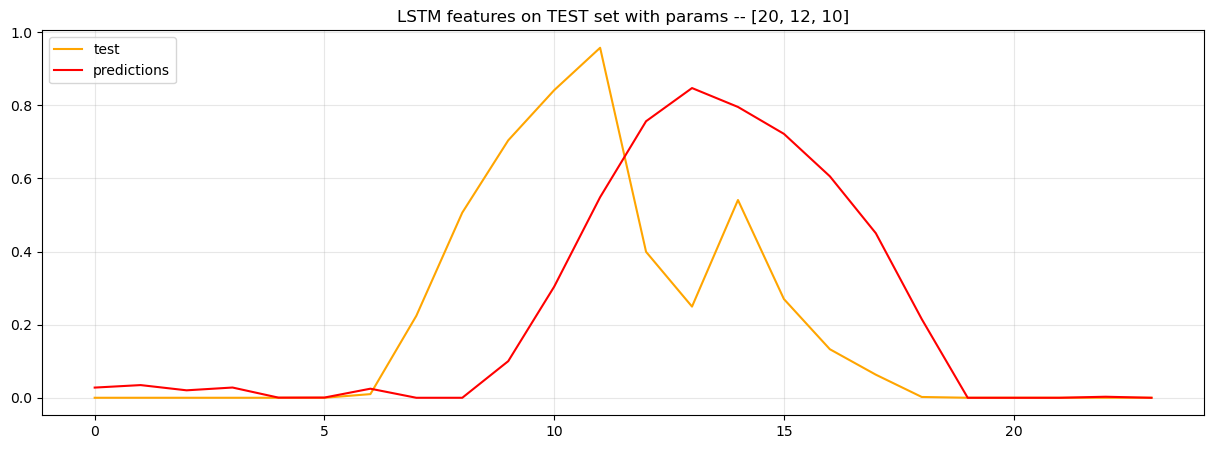

weighted_score --  5303597.898036132


NameError: name 'SHIFT' is not defined

In [72]:
test_ML_DL_models(hourly_radiation_df, hourly_radiation_df['Radiation'], 'additive_radiation', True, True)

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
multiplicative_ML_DL_results_df = test_ML_DL_models(multiplicative_decomposed_production, 'multiplicative_decomposed_production', False, False)
multiplicative_ML_DL_results_df

In [113]:
additive_ML_DL_results_df = test_ML_DL_models(additive_decomposed_production, 'additive_decomposed_production', False, False)
additive_ML_DL_results_df

NameError: name 'additive_decomposed_production' is not defined

<a id='section_6'></a>
## Section 6. Fbprophet and Nbeats models

### Usage of Facebook Prophet Library

In [1250]:
def fit_Prophet(train_dates, train_vals, params):
    m = Prophet(seasonality_mode=params[0],
                growth=params[1],
                yearly_seasonality=True,
                daily_seasonality=True)

    m.add_country_holidays(country_name='US')
    m.add_seasonality(name='monthly', period=FORECAST_PERIOD, fourier_order=params[2])

    ptrain = pd.DataFrame()
    ptrain["ds"] = train_dates
    ptrain["y"] = train_vals

    ptrain['floor'] = ptrain['y'].min()
    ptrain['cap'] = ptrain['y'].max()

    m.fit(ptrain)
    return m, ptrain

In [1251]:
def get_train_validation_test_splits_for_Prophet(production_ts):
    train_lengths = [201 - MAX_DF_SHIFT]
    validate_length = FORECAST_PERIOD # also equal to test length

    splits = []
    for train_length in train_lengths:
        train = (production_ts.index[: train_length], production_ts.values[: train_length])
        validate = (production_ts.index[train_length: train_length + validate_length], production_ts.values[train_length: train_length + validate_length])
        train_validate = (production_ts.index[:train_length + validate_length], production_ts.values[:train_length + validate_length])
        test = (production_ts.index[train_length + validate_length: train_length + 2 * validate_length],
                production_ts.values[train_length + validate_length: train_length + 2 * validate_length])

        splits.append((train, validate, test, train_validate))

    return splits

In [1252]:
def optimize_Prophet_model(params_list, stationary_series_name, model_name, full_df_split,
                           show_plots, debug_mode):
    print('#' * 60, model_name, '#' * 60, '\n' * 2)

    min_weighted_score = 100
    best_model = dict()

    train, validate, test, train_valid = full_df_split
    X_test, y_test = test
    X_train_valid, y_train_valid = train_valid

    val_interval = FORECAST_PERIOD

    # find the best params for the model based on validation set
    best_model['params'] = params_list[0]
    for params in params_list:
        model, ptrain = fit_Prophet(X_train_valid, y_train_valid, params)
        cutoffs = pd.to_datetime(['2013-03-01', '2014-03-01', '2015-03-01'])
        df_cv = cross_validation(model, cutoffs=cutoffs, horizon='365 days', disable_tqdm=True)
        df_p = performance_metrics(df_cv, rolling_window=1)
        model_forecast_accuracy = df_p['mape'][0]

        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Params -- ', params)
            print(df_p)

        if model_forecast_accuracy <= min_weighted_score:
            min_weighted_score = model_forecast_accuracy
            best_model['Params'] = params
            best_model['prediction'] = df_cv
            best_model['model_accuracy'] = model_forecast_accuracy

    if show_plots:
        plt.plot(best_model['prediction']['ds'], best_model['prediction']['y'], color='orange', label="test")
        plt.plot(best_model['prediction']['ds'], best_model['prediction']['yhat'], color='red', label="predictions")
        plt.legend(loc='upper left')
        plt.title(f'{model_name} with params -- {best_model["params"]}')
        plt.grid(alpha=0.3)
        plt.show()

    # test our model
    test_model, ptrain = fit_Prophet(X_train_valid, y_train_valid, best_model['params'])
    future = test_model.make_future_dataframe(periods=val_interval, include_history=True, freq="m")
    future['floor'] = ptrain['y'].min()
    future['cap'] = ptrain['y'].max()

    forecast = test_model.predict(future)

    y_test_pred = forecast[["yhat"]][-FORECAST_PERIOD:].values.flatten()

    # return to initial series
    start_idx = len(y_train_valid) + MAX_DF_SHIFT
    end_idx = start_idx + FORECAST_PERIOD
    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    best_model_test_accuracy = forecast_accuracy(y_test_pred,
                                                OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT].to_numpy())
    pprint(best_model_test_accuracy)

    x_indices = range(start_idx + SHIFT, end_idx + SHIFT)

    # add + 1 to make consistent plot
    plt.plot(OtherPEN_production.Production[:start_idx + SHIFT + 1], color='blue', label="train")
    plt.plot(OtherPEN_production.Production[start_idx + SHIFT: end_idx + SHIFT], color='orange', label="test")
    plt.plot(x_indices, y_test_pred, color='red', label="predictions")
    plt.legend(loc='upper left')
    plt.title(f'{model_name} {best_model["params"]} Prediction on Test Dataset')
    plt.grid(alpha=0.3)
    plt.show()

    # In this lab I decided to stay decomposed stationary series as they showed the best performance during my testing and
    # also them showed the best performance for HW_1. In such a way I also reduce time to run this notebok by yourself.

    # else:
    #     if 'multiplicative' in stationary_series_name:
    #         prediction = np.exp(prediction)
    #
    #     best_model_prediction_initial_series, best_model_test_accuracy =\
    #         return_to_initial_series_additive_differencing(prediction, len(train_validate_set),
    #                                                        best_model['(p, d, q)'], stationary_series_name, model_name, show_plots)

    return y_test_pred, best_model['params'], best_model_test_accuracy

In [1253]:
def test_Prophet_model(full_df, series_name, show_plots, debug_mode):
    full_df_split = get_train_validation_test_splits_for_Prophet(full_df)[0]

    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Params',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    # seasonality_mode_lst = ['additive', 'multiplicative']
    # growth_lst = ['linear', 'logistic']
    # fourier_params_lst = [3, 4, 5]
    # params_list = [seasonality_mode_lst, growth_lst, fourier_params_lst]
    # params_list = list(itertools.product(*params_list))
    params_list = [['multiplicative', 'linear', 4]]

    best_model_prediction_initial_series, best_model_params, best_model_test_accuracy =\
        optimize_Prophet_model(params_list, series_name, 'FBProphet', full_df_split, show_plots, debug_mode)
    results_df.loc[i] = [3, series_name,
                         'FBProphet', best_model_params,
                         best_model_test_accuracy['1. Mean Absolute Percentage Error (MAPE)'],
                         best_model_test_accuracy['2. Mean Percentage Error (MPE)'],
                         best_model_test_accuracy['3. Root Mean Squared Error (RMSE)']]

    return results_df

In [1254]:
DATA = process_data(production_df, rainfall_df, area_df, OtherPEN_production.Production[SHIFT: -SHIFT], REGIONS, STATIONARY_PRODUCTION_LAGS, RAINFALL_LAGS)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


############################################################ FBProphet ############################################################ 


Initial log joint probability = -4.85799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       425.692     0.0277211       75.8936      0.4961      0.4961      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175        430.46   0.000346274       130.512   5.608e-06       0.001      258  LS failed, Hessian reset 
     199       430.883   0.000341731        71.616       0.531       0.531      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       431.113    0.00107132       100.988   2.228e-05       0.001      345  LS failed, Hessian reset 
     244       431.312   0.000921764        216.34   1.228e-05       0.001      433  LS failed, Hessian reset 
     299       431.423   5.42293e-05     

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -4.85799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       425.692     0.0277211       75.8936      0.4961      0.4961      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175        430.46   0.000346274       130.512   5.608e-06       0.001      258  LS failed, Hessian reset 
     199       430.883   0.000341731        71.616       0.531       0.531      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       431.113    0.00107132       100.988   2.228e-05       0.001      345  LS failed, Hessian reset 
     244       431.312   0.000921764        216.34   1.228e-05       0.001      433  LS failed, Hessian reset 
     299       431.423   5.42293e-05       67.8356           1           1      516   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

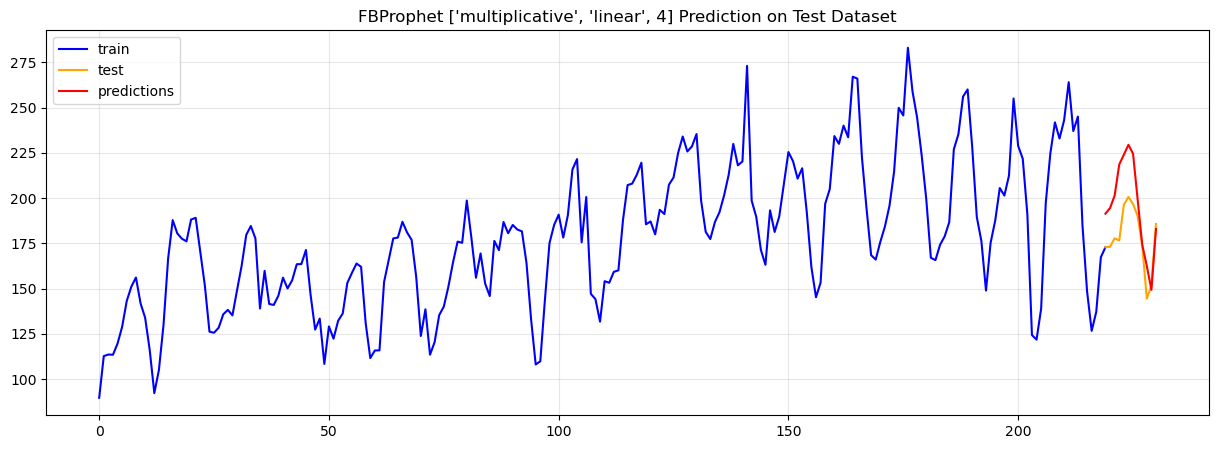

In [1255]:
prophet_results_df = test_Prophet_model(DATA['Other Pen. States'][1], 'real production data', False, False)

### [Extra task] Usage of N-Beats Library

In [1256]:
import torch
from torch import optim
from torch.nn import functional as F

from nbeats_pytorch.model import NBeatsNet

In [1257]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)

def plot_scatter_without_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)

# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

In [1258]:
def train_test_Nbeats(x_train, y_train, x_test, y_test, params, forecast_length,
                      backcast_length, norm_constant, show_plots):
    batch_size = 10  # greater than 4 for viz

    # model
    net = NBeatsNet(
        stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
        forecast_length=forecast_length,
        backcast_length=backcast_length,
        hidden_layer_units=params,
    )
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())

    grad_step = 0
    forecast = []
    final_forecast = []
    for epoch in range(300):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        test_loss = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p = forecast.detach().numpy()
        final_forecast = p
        if show_plots and epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')

    return final_forecast

In [1259]:
def get_train_test(prod_values, backcast_length, forecast_length):
    x, y = [], []
    for epoch in range(backcast_length, len(prod_values) - forecast_length):
        x.append(prod_values[epoch - backcast_length:epoch])
        y.append(prod_values[epoch:epoch + forecast_length])

    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test = x[c:], y[c:]
    norm_constant = np.max(x_train)


    # normalization.
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test = x_test / norm_constant, y_test / norm_constant
    return x_train, y_train, x_test, y_test, norm_constant

In [1260]:
def optimize_Nbeats_model(params_list, train_validate_values, all_values, show_plots, debug_mode):
    best_model = dict()
    min_weighted_score = 1000_000
    forecast_length = 12
    backcast_length = 3 * forecast_length

    # data backcast/forecast generation.
    x_train, y_train, x_test, y_test, norm_constant = get_train_test(train_validate_values, backcast_length, forecast_length)

    # find the best params for the model based on validation set
    best_model['params'] = params_list[0]
    for params in params_list:
        y_pred = train_test_Nbeats(x_train, y_train, x_test, y_test, params, forecast_length,
                                   backcast_length, norm_constant, show_plots)
        y_pred, xx, yy = y_pred[-1] * norm_constant, x_test[-1] * norm_constant, y_test[-1] * norm_constant
        model_forecast_accuracy = forecast_accuracy(y_pred, yy)

        if debug_mode:
            print('\n' * 2, '=' * 20, 'Forecast Accuracy', '=' * 20)
            print('Params -- ', params)
            pprint(model_forecast_accuracy)

        # weighted_score
        weighted_score = 0.5 * (model_forecast_accuracy['1. Mean Absolute Percentage Error (MAPE)'] ** 2) +\
                         0.5 * (model_forecast_accuracy['2. Mean Percentage Error (MPE)'] ** 2)

        if weighted_score <= min_weighted_score:
            min_weighted_score = weighted_score
            best_model['params'] = params
            best_model['prediction'] = y_pred
            best_model['model_accuracy'] = model_forecast_accuracy

    if show_plots:
        plt.figure(1)
        plot_scatter(range(0, backcast_length), xx, color='b')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), best_model['prediction'], color='r')
        plt.show()

    # test our model
    x_train2, y_train2, x_test2, y_test2, norm_constant2 = get_train_test(all_values, backcast_length, forecast_length)
    y_test_pred = train_test_Nbeats(x_train2, y_train2, x_test2, y_test2, best_model['params'], forecast_length,
                               backcast_length, norm_constant2, show_plots)
    y_test_pred, xx, yy = y_test_pred[-1] * norm_constant, x_test2[-1] * norm_constant, y_test2[-1] * norm_constant
    best_model_test_accuracy = forecast_accuracy(y_test_pred, yy)

    print('\n' * 2, '=' * 20, 'Forecast Accuracy on Test Set', '=' * 20)
    pprint(best_model_test_accuracy)



    plt.figure(1)
    end_train_set = len(OtherPEN_production.Production) - forecast_length - SHIFT
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), y_test_pred, color='r')
    plt.show()

    plot_scatter_without_scatter(range(0, end_train_set),
                                 OtherPEN_production.Production[:-forecast_length - SHIFT], color='b')
    plot_scatter_without_scatter(range(end_train_set, end_train_set + forecast_length), yy, color='g')
    plot_scatter_without_scatter(range(end_train_set, end_train_set + forecast_length), y_test_pred, color='r')
    plt.show()

    return y_test_pred, best_model['params'], best_model_test_accuracy

In [1261]:
def test_Nbeats_model(time_series, series_name, show_plots, debug_mode):
    results_df = pd.DataFrame(columns=('Iteration', 'Stationary_Series_Name', 'Model_Name', 'Model_Params',
                                       'Mean Absolute Percentage Error (MAPE)',
                                       'Mean Percentage Error (MPE)',
                                       'Root Mean Squared Error (RMSE)'))

    # params_list = [32, 64, 128]
    params_list = [128]

    # for Prophet and Nbeats libraries I should not make  cross validation as for Prophet I used cross_validation function of this library
    # and for Nbeats we also have cross validation
    best_model_prediction_initial_series, best_model_params, best_model_test_accuracy =\
        optimize_Nbeats_model(params_list, time_series[:-FORECAST_PERIOD], time_series, show_plots, debug_mode)

    results_df.loc[i] = [3, series_name,
                         'Nbeats', best_model_params,
                         best_model_test_accuracy['1. Mean Absolute Percentage Error (MAPE)'],
                         best_model_test_accuracy['2. Mean Percentage Error (MPE)'],
                         best_model_test_accuracy['3. Root Mean Squared Error (RMSE)']]

    return results_df

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507342160
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507343056
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=36, forecast_length=12, share_thetas=False) at @139754500548752
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507270160
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507270544
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=36, forecast_length=12, share_thetas=False) at @139755507272848


 ==================== Forecast Accuracy ====================
Order --  128
{'1. Mean Absolute Percentage Err

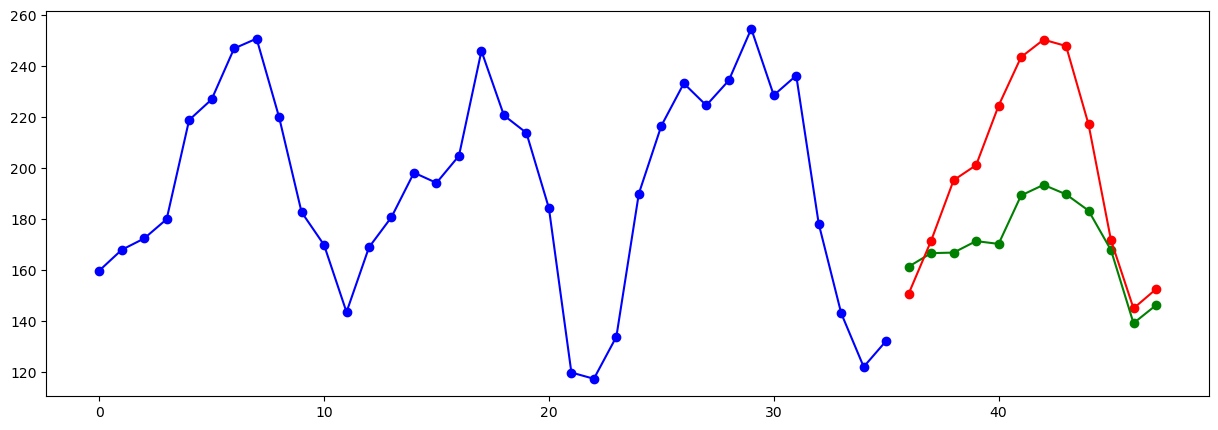

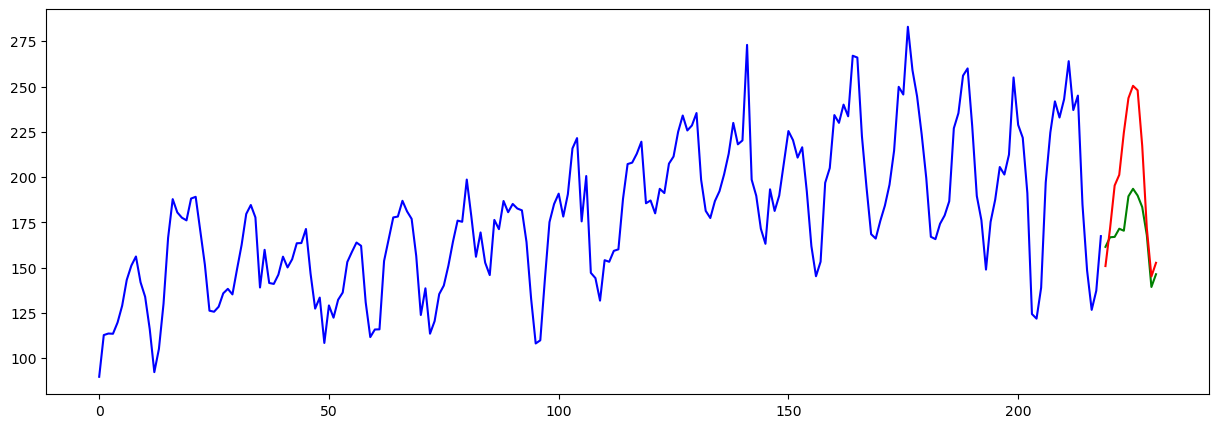

,Iteration,Stationary_Series_Name,Model_Name,Model_Orders,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
20,3,original production data,Nbeats,128,0.161269,0.150313,35.998372


In [1262]:
Nbeats_results_df = test_Nbeats_model(OtherPEN_production.Production[SHIFT: -SHIFT].values, 'original production data', False, True)
Nbeats_results_df

### Best Forcasts of AR, MA, ARMA and ARIMA models (based on Cross-Validation)

In [1263]:
total_results_df = pd.concat([
    additive_ML_DL_results_df,
    multiplicative_ML_DL_results_df,
    prophet_results_df,
    Nbeats_results_df
])
total_results_df

,Iteration,Stationary_Series_Name,Model_Name,Model_Orders,Mean Absolute Percentage Error (MAPE),Mean Percentage Error (MPE),Root Mean Squared Error (RMSE)
0,1,additive_decomposed_production,Conv1d model,"[30, 64, 400]",0.114711,0.070459,22.908938
1,2,additive_decomposed_production,LSTM,"[20, 12, 400]",0.050527,-0.017167,13.735057
2,3,additive_decomposed_production,Random Forest,"[1000, 100]",0.138323,0.119438,31.766511
0,1,multiplicative_decomposed_production,Random Forest,"[100, 100]",0.104594,0.061418,20.768534
1,2,multiplicative_decomposed_production,LSTM,"[20, 12, 400]",0.056375,-0.002823,14.397626
2,3,multiplicative_decomposed_production,XGBoost,"[100, 4, 1]",0.133673,0.121817,29.934821
20,3,real production data,FBProphet,"[multiplicative, linear, 4]",0.102696,0.097650,22.196593
20,3,original production data,Nbeats,128,0.161269,0.150313,35.998372


### Conclusion

From the above dataframe we see that prediction **on multiplicative decomposed values** is the best. For this multiplicative time series LSTM showed the best result as it has the smallest error from different measurements. LSTM showed **the best result for the second iteration of cross validation** and during my testing and debugging also was **pretty close to SimpleRNN on the third iteration**. On my notebook execution LSTM got such results.

That's why for forecasting out of our time series I chosen LSTM.

| Stationary_Series_Name | Model_Name | Model_Orders | Mean Absolute Percentage Error (MAPE) | Mean Percentage Error (MPE) | Root Mean Squared Error (RMSE) |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| multiplicative_decomposed_production | LSTM | [20, 12, 400] | 0.045044 | -0.011372 | 12.012046 |

<a id='section_7'></a>
## Section 7. Predict on 12 months out of dataframe

In [58]:
def get_extrapolated_trend(trend):
    X = trend.index[:, np.newaxis]
    y = trend.values[:, np.newaxis]

    poly_reg = PolynomialFeatures(degree=2)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)

    predict_idx = np.array([trend.index[-1] + i for i in range(1, 13)])
    X_actual_and_forecast = np.concatenate((X, predict_idx[:, np.newaxis]))
    polynomial_trend_prediction = pol_reg.predict(poly_reg.fit_transform(X_actual_and_forecast))

    # Visualizing the Polymonial Regression results
    plt.scatter(X, y, color='red')
    plt.plot(X_actual_and_forecast, polynomial_trend_prediction, color='blue')
    plt.ylabel('Production')
    plt.title('Extrapolation of trend')
    plt.show()

    return polynomial_trend_prediction.flatten()

In [59]:
def extrapolate_seasonality(seasonality, num_periods):
    new_seasonality = pd.concat([seasonality, seasonality[:num_periods * FORECAST_PERIOD]])
    new_seasonality.index = range(0, len(new_seasonality))
    plt.plot(new_seasonality)
    plt.title('Extrapolation of seasonality')
    plt.show()
    return new_seasonality

In [62]:
def get_train_validation_test_splits_for_final_test(values):
    train_length = 201 - MAX_DF_SHIFT
    validate_length = FORECAST_PERIOD # also equal to test length

    test = values[train_length + validate_length: train_length + 2 * validate_length, :]

    test_X, test_y = test[:, :-1], test[:, -1]
    full_df_X, full_df_y = values[:, :-1], values[:, -1]

    return [(test_X, test_y), (full_df_X, full_df_y)]


def predict_out_of_df(stationary_series, best_model_params, model_name):
    full_df, SCALER = create_feature_df_for_stationary(stationary_series)
    test, full_df_split = get_train_validation_test_splits_for_final_test(full_df)
    test_X, test_y = test
    full_df_X, full_df_y = full_df_split

    # reshape input to be 3D [samples, timesteps, features]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    full_df_X = full_df_X.reshape((full_df_X.shape[0], 1, full_df_X.shape[1]))

    test_model = fit_LSTM_features(full_df_X, full_df_y, None, None, best_model_params, True)

    yhat = test_model_with_transform(test_model, test_X, model_name, -1)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert scaling for forecast
    inv_yhat = np.concatenate((test_X, yhat), axis=1)
    inv_yhat = SCALER.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-1]

    predicted_trend = extrapolate_seasonality(multiplicative_decomposed_seasonal, 1)[-FORECAST_PERIOD:]
    predicted_seasonality = get_extrapolated_trend(multiplicative_decomposed_trend)[-FORECAST_PERIOD:]

    model_prediction_initial_series = inv_yhat * predicted_trend * predicted_seasonality

    start_idx = len(OtherPEN_production.Production[:-SHIFT])
    end_idx = start_idx + FORECAST_PERIOD
    x_indices = range(start_idx, end_idx)
    print("model_prediction_initial_series -- ", model_prediction_initial_series.values)

    # add + 1 to make consistent plot
    plt.plot(OtherPEN_production.Production[:-SHIFT], color='blue', label="initial time series")
    plt.plot(x_indices, model_prediction_initial_series, color='red', label="predictions")
    plt.legend(loc='upper left')
    plt.title(f'{model_name} {best_model_params} Prediction on Test Dataset')
    plt.grid(alpha=0.3)
    plt.show()

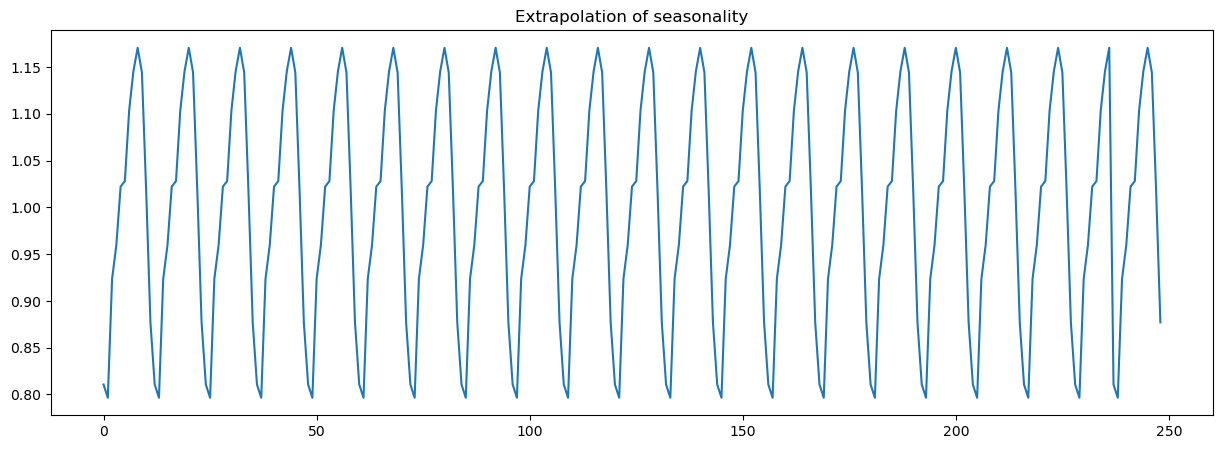

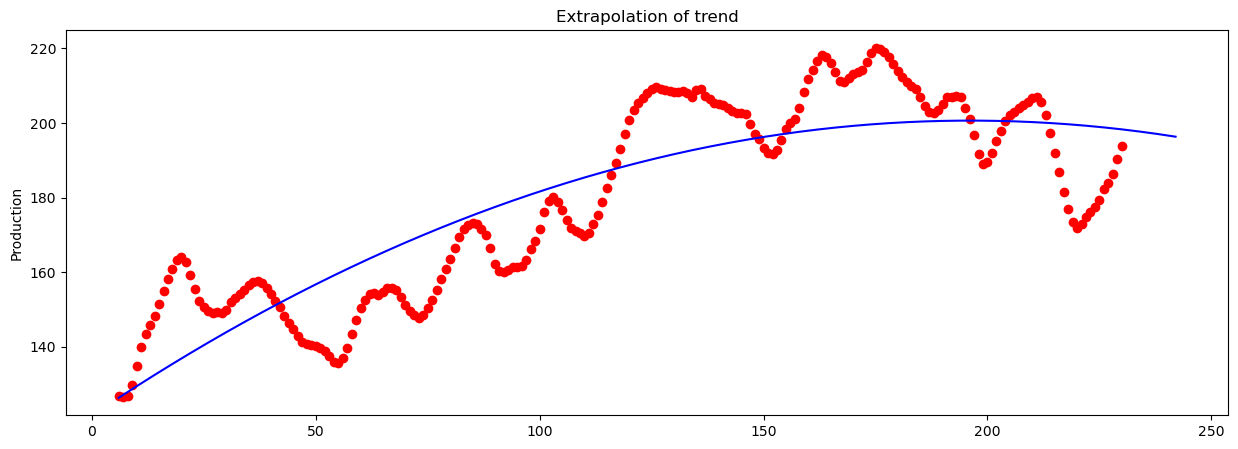

model_prediction_initial_series --  [163.55833909 153.91934745 173.98519977 186.14253405 204.555527
 206.65170645 219.53063643 228.28314515 226.29864213 220.41687323
 189.08903556 168.33094131]


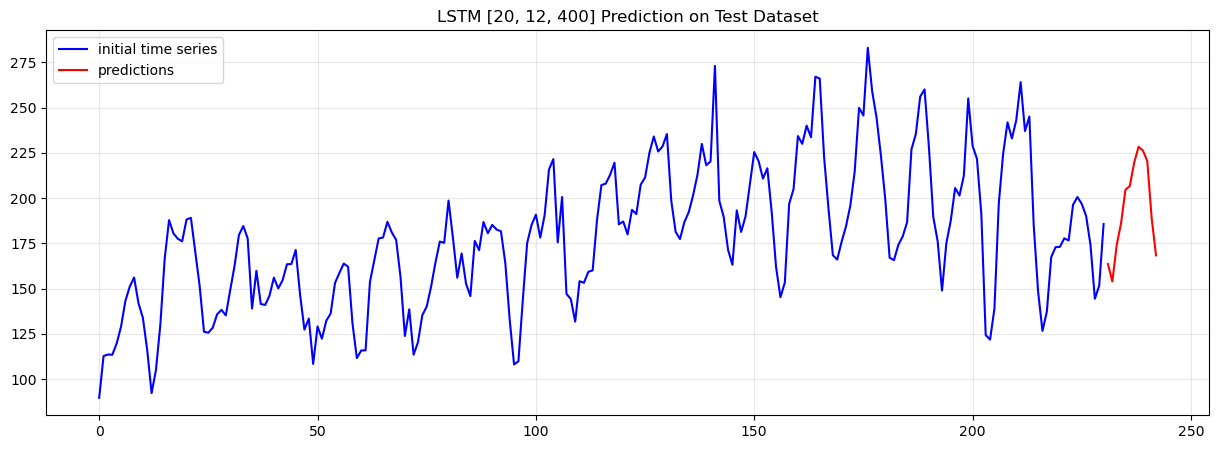

In [63]:
predict_out_of_df(multiplicative_decomposed_production, [20, 12, 400], 'LSTM')